In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

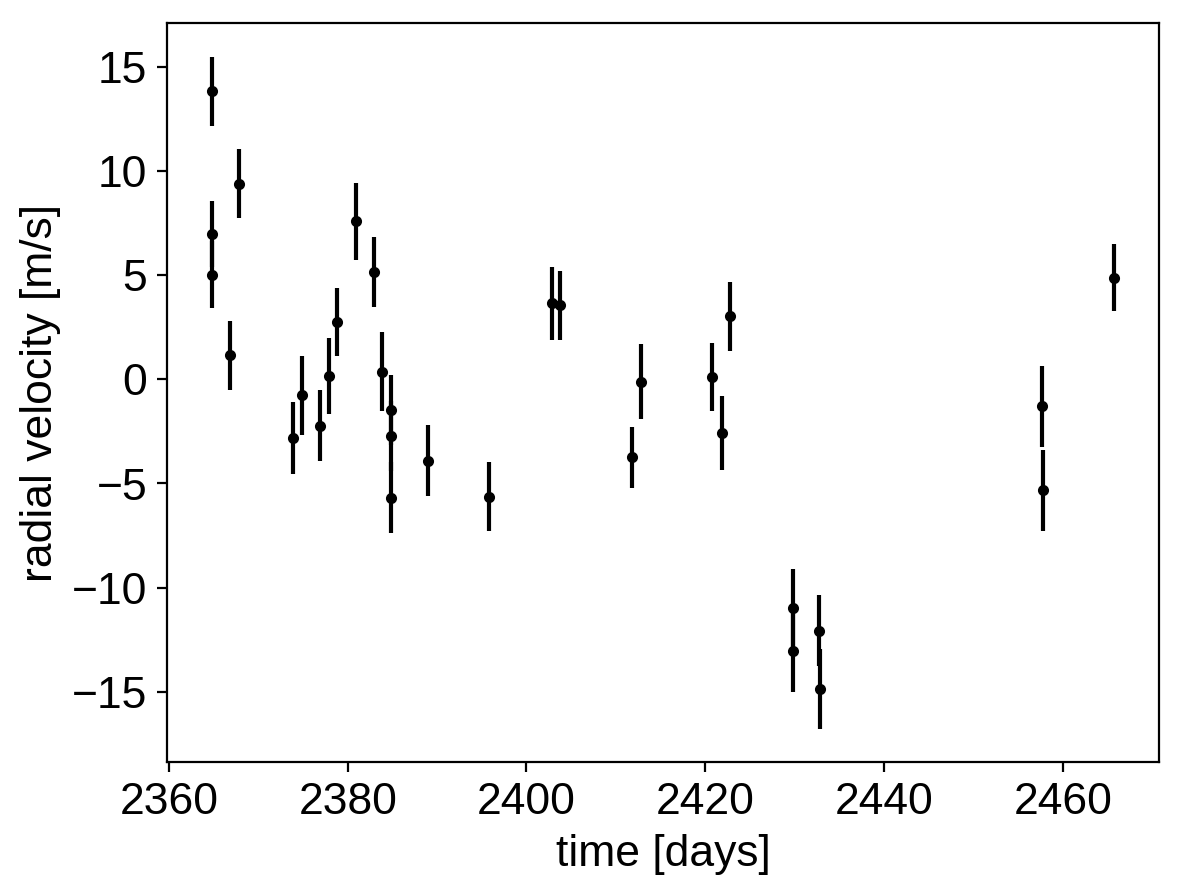

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=2,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=2, testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)

    # Define the background model
    A = np.vander(x - 0.5 * (x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))

    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5 * (x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic(
        "rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred
    )

Now, we can plot the initial model:

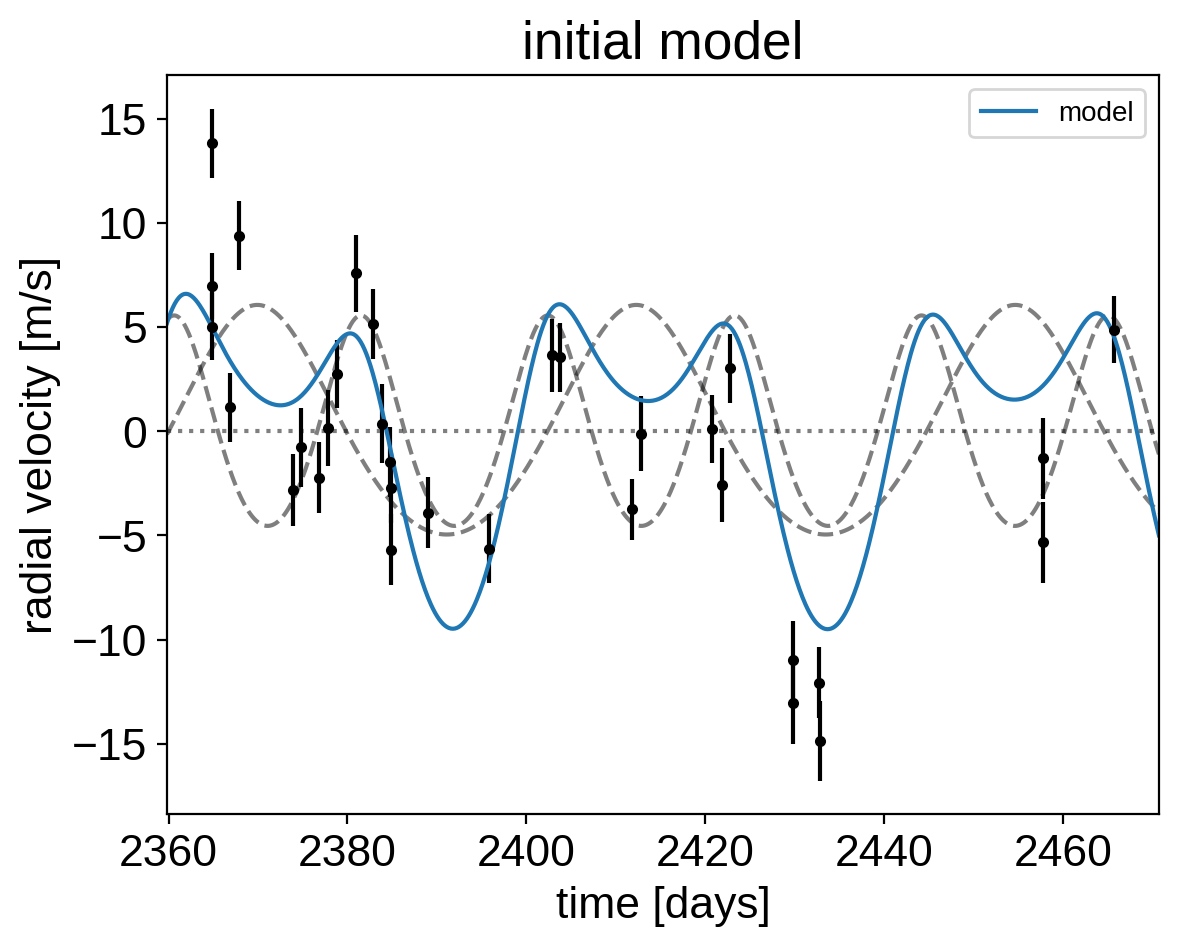

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:

    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-7.973266e+01]

1it [00:00, 250.59it/s, logp=-7.973266e+01]

2it [00:00, 347.83it/s, logp=-7.973266e+01]

3it [00:00, 372.95it/s, logp=-5.305392e+06]

4it [00:00, 413.34it/s, logp=-7.966783e+01]

5it [00:00, 418.02it/s, logp=-7.953812e+01]

6it [00:00, 426.18it/s, logp=-7.904438e+01]

7it [00:00, 409.15it/s, logp=-7.747076e+01]

8it [00:00, 401.60it/s, logp=-7.344108e+01]

9it [00:00, 400.36it/s, logp=-6.722892e+01]

10it [00:00, 335.27it/s, logp=-6.484820e+01]

11it [00:00, 341.72it/s, logp=-6.484820e+01]

12it [00:00, 351.53it/s, logp=-6.484820e+01]

13it [00:04,  3.01it/s, logp=-6.484820e+01] 


message: Optimization terminated successfully.
logp: -79.73266285618838 -> -64.8482026233154


optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.484820e+01]

1it [00:00, 211.63it/s, logp=-6.484820e+01]

2it [00:00, 296.83it/s, logp=-6.484820e+01]

3it [00:00, 327.23it/s, logp=-4.990134e+09]

4it [00:00, 354.26it/s, logp=-6.484832e+01]

5it [00:00, 376.11it/s, logp=-6.484777e+01]

6it [00:00, 374.11it/s, logp=-6.519268e+01]

7it [00:00, 381.59it/s, logp=-6.484777e+01]

8it [00:00, 383.79it/s, logp=-6.484777e+01]

9it [00:00, 377.83it/s, logp=-6.484776e+01]

10it [00:00, 361.59it/s, logp=-6.484774e+01]

11it [00:00, 348.34it/s, logp=-6.484767e+01]

12it [00:00, 348.06it/s, logp=-6.484739e+01]

13it [00:00, 349.32it/s, logp=-6.484633e+01]

14it [00:00, 342.91it/s, logp=-6.484353e+01]

15it [00:00, 343.29it/s, logp=-6.483426e+01]

16it [00:00, 335.33it/s, logp=-6.481055e+01]

17it [00:00, 331.50it/s, logp=-6.472940e+01]

18it [00:00, 324.17it/s, logp=-6.451928e+01]

19it [00:00, 322.93it/s, logp=-6.371170e+01]

20it [00:00, 323.14it/s, logp=-6.096678e+01]

21it [00:00, 320.84it/s, logp=-5.708652e+01]

22it [00:00, 319.85it/s, logp=-5.027536e+01]

23it [00:00, 315.58it/s, logp=-2.386568e+02]

24it [00:00, 312.51it/s, logp=-4.912172e+01]

25it [00:00, 312.67it/s, logp=-4.707357e+01]

26it [00:00, 308.87it/s, logp=-4.319328e+01]

27it [00:00, 308.40it/s, logp=-3.608487e+01]

28it [00:00, 310.13it/s, logp=-2.498567e+01]

29it [00:00, 308.52it/s, logp=-2.442071e+01]

30it [00:00, 308.51it/s, logp=-2.333036e+01]

31it [00:00, 311.52it/s, logp=-2.011091e+01]

32it [00:00, 319.71it/s, logp=-2.011091e+01]

32it [00:00, 319.71it/s, logp=-1.751350e+01]

33it [00:00, 319.71it/s, logp=-1.714559e+01]

34it [00:00, 319.71it/s, logp=-1.693796e+01]

35it [00:00, 319.71it/s, logp=-1.684943e+01]

36it [00:00, 319.71it/s, logp=-1.676095e+01]

37it [00:00, 319.71it/s, logp=-1.673569e+01]

38it [00:00, 319.71it/s, logp=-1.672214e+01]

39it [00:00, 319.71it/s, logp=-1.670758e+01]

40it [00:00, 319.71it/s, logp=-1.668064e+01]

41it [00:00, 319.71it/s, logp=-1.662858e+01]

42it [00:00, 319.71it/s, logp=-1.658058e+01]

43it [00:00, 319.71it/s, logp=-1.655728e+01]

44it [00:00, 319.71it/s, logp=-1.662929e+01]

45it [00:00, 319.71it/s, logp=-1.647872e+01]

46it [00:00, 319.71it/s, logp=-1.635178e+01]

47it [00:00, 319.71it/s, logp=-1.613280e+01]

48it [00:00, 319.71it/s, logp=-1.577352e+01]

49it [00:00, 319.71it/s, logp=-1.525205e+01]

50it [00:00, 319.71it/s, logp=-1.849895e+01]

51it [00:00, 319.71it/s, logp=-1.514689e+01]

52it [00:00, 319.71it/s, logp=-1.501721e+01]

53it [00:00, 319.71it/s, logp=-1.496658e+01]

54it [00:00, 319.71it/s, logp=-1.495457e+01]

55it [00:00, 319.71it/s, logp=-1.494704e+01]

56it [00:00, 319.71it/s, logp=-1.494509e+01]

57it [00:00, 319.71it/s, logp=-1.494181e+01]

58it [00:00, 319.71it/s, logp=-1.493619e+01]

59it [00:00, 319.71it/s, logp=-1.492655e+01]

60it [00:00, 319.71it/s, logp=-1.491151e+01]

61it [00:00, 319.71it/s, logp=-1.489345e+01]

62it [00:00, 319.71it/s, logp=-1.486580e+01]

63it [00:00, 319.71it/s, logp=-1.483881e+01]

64it [00:00, 319.71it/s, logp=-1.479783e+01]

65it [00:00, 319.71it/s, logp=-1.475797e+01]

66it [00:00, 319.71it/s, logp=-1.470224e+01]

67it [00:00, 319.71it/s, logp=-1.466581e+01]

68it [00:00, 319.71it/s, logp=-1.465792e+01]

69it [00:00, 319.71it/s, logp=-1.460984e+01]

70it [00:00, 319.71it/s, logp=-1.453216e+01]

71it [00:00, 319.71it/s, logp=-1.441150e+01]

72it [00:00, 319.71it/s, logp=-1.431230e+01]

73it [00:00, 319.71it/s, logp=-1.436794e+01]

74it [00:00, 319.71it/s, logp=-1.429690e+01]

75it [00:00, 319.71it/s, logp=-1.428194e+01]

76it [00:00, 319.71it/s, logp=-1.427769e+01]

77it [00:00, 319.71it/s, logp=-1.427703e+01]

78it [00:00, 319.71it/s, logp=-1.427688e+01]

79it [00:00, 319.71it/s, logp=-1.427678e+01]

80it [00:00, 354.27it/s, logp=-1.427678e+01]

80it [00:00, 354.27it/s, logp=-1.427677e+01]

81it [00:00, 354.27it/s, logp=-1.427676e+01]

82it [00:00, 354.27it/s, logp=-1.427676e+01]

83it [00:00, 354.27it/s, logp=-1.427676e+01]

84it [00:00, 354.27it/s, logp=-1.427676e+01]

85it [00:00, 354.27it/s, logp=-1.427676e+01]

86it [00:00, 354.27it/s, logp=-1.427676e+01]

87it [00:00, 354.27it/s, logp=-1.427676e+01]

88it [00:00, 354.27it/s, logp=-1.427676e+01]

89it [00:00, 354.27it/s, logp=-1.427676e+01]

90it [00:00, 354.27it/s, logp=-1.427676e+01]

91it [00:00, 354.27it/s, logp=-1.427676e+01]

92it [00:00, 354.27it/s, logp=-1.427676e+01]

93it [00:00, 354.27it/s, logp=-1.427676e+01]

94it [00:00, 180.82it/s, logp=-1.427676e+01]


message: Optimization terminated successfully.
logp: -64.8482026233154 -> -14.276760262380932


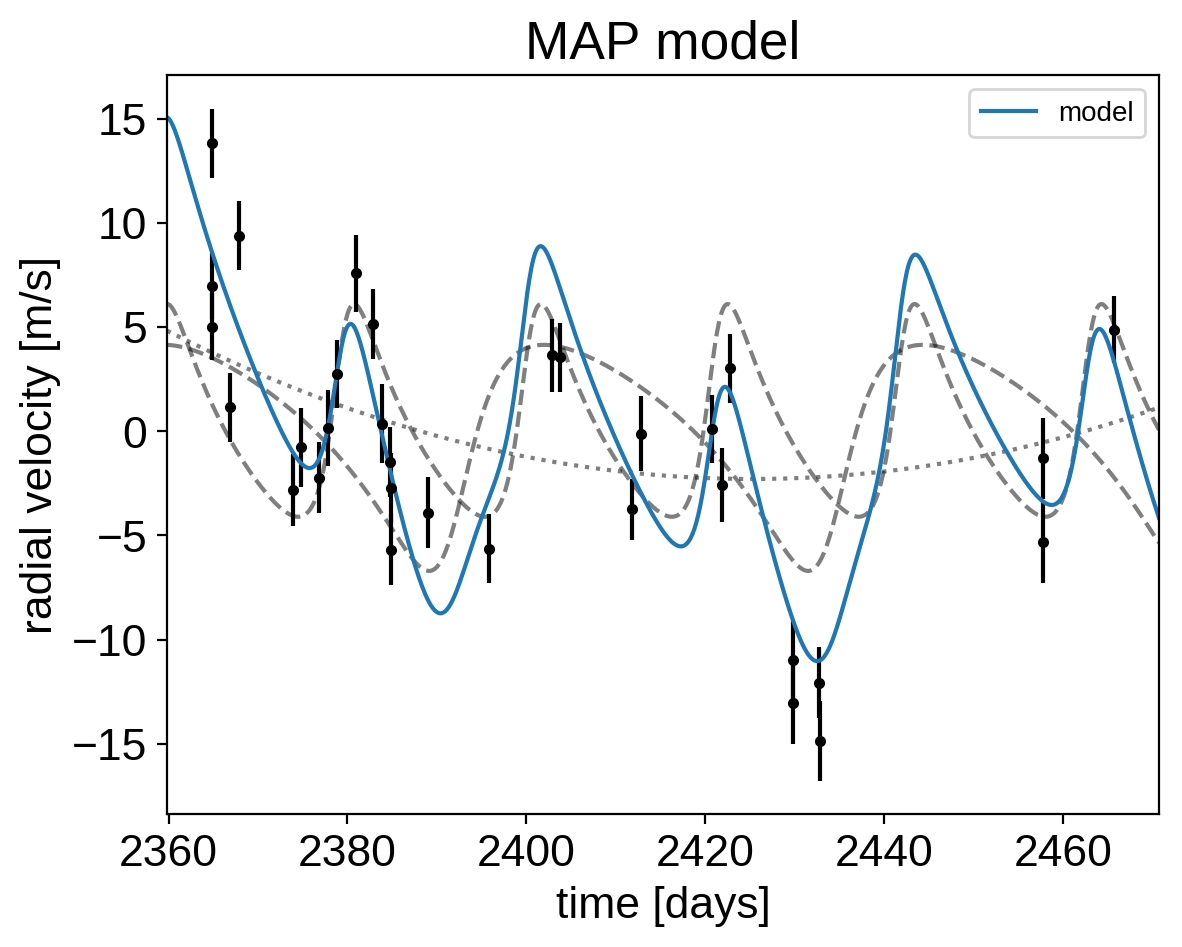

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :func:`exoplanet.get_dense_nuts_step` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000, draws=4000, step=xo.get_dense_nuts_step(target_accept=0.95)
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 17/32000 [00:00<03:11, 167.34draws/s]

Sampling 4 chains:   0%|          | 25/32000 [00:00<04:54, 108.57draws/s]

Sampling 4 chains:   0%|          | 33/32000 [00:00<05:45, 92.62draws/s] 

Sampling 4 chains:   0%|          | 41/32000 [00:00<06:20, 84.02draws/s]

Sampling 4 chains:   0%|          | 48/32000 [00:00<06:44, 79.02draws/s]

Sampling 4 chains:   0%|          | 56/32000 [00:00<07:05, 75.15draws/s]

Sampling 4 chains:   0%|          | 64/32000 [00:00<07:18, 72.80draws/s]

Sampling 4 chains:   0%|          | 72/32000 [00:00<07:22, 72.13draws/s]

Sampling 4 chains:   0%|          | 80/32000 [00:01<07:31, 70.76draws/s]

Sampling 4 chains:   0%|          | 88/32000 [00:01<07:30, 70.78draws/s]

Sampling 4 chains:   0%|          | 96/32000 [00:01<07:30, 70.81draws/s]

Sampling 4 chains:   0%|          | 104/32000 [00:01<07:31, 70.72draws/s]

Sampling 4 chains:   0%|          | 111/32000 [00:01<07:36, 69.82draws/s]

Sampling 4 chains:   0%|          | 118/32000 [00:01<07:55, 66.98draws/s]

Sampling 4 chains:   0%|          | 125/32000 [00:01<08:03, 65.91draws/s]

Sampling 4 chains:   0%|          | 133/32000 [00:01<07:54, 67.10draws/s]

Sampling 4 chains:   0%|          | 141/32000 [00:01<07:56, 66.82draws/s]

Sampling 4 chains:   0%|          | 149/32000 [00:02<07:49, 67.85draws/s]

Sampling 4 chains:   0%|          | 157/32000 [00:02<07:43, 68.75draws/s]

Sampling 4 chains:   1%|          | 165/32000 [00:02<07:38, 69.43draws/s]

Sampling 4 chains:   1%|          | 173/32000 [00:02<07:35, 69.86draws/s]

Sampling 4 chains:   1%|          | 180/32000 [00:02<07:39, 69.27draws/s]

Sampling 4 chains:   1%|          | 187/32000 [00:02<07:57, 66.63draws/s]

Sampling 4 chains:   1%|          | 195/32000 [00:02<07:51, 67.41draws/s]

Sampling 4 chains:   1%|          | 203/32000 [00:02<07:46, 68.17draws/s]

Sampling 4 chains:   1%|          | 211/32000 [00:02<07:38, 69.40draws/s]

Sampling 4 chains:   1%|          | 219/32000 [00:03<07:30, 70.48draws/s]

Sampling 4 chains:   1%|          | 227/32000 [00:03<07:28, 70.79draws/s]

Sampling 4 chains:   1%|          | 235/32000 [00:03<07:34, 69.87draws/s]

Sampling 4 chains:   1%|          | 242/32000 [00:03<07:44, 68.41draws/s]

Sampling 4 chains:   1%|          | 249/32000 [00:03<07:54, 66.88draws/s]

Sampling 4 chains:   1%|          | 256/32000 [00:03<08:02, 65.80draws/s]

Sampling 4 chains:   1%|          | 264/32000 [00:03<07:55, 66.68draws/s]

Sampling 4 chains:   1%|          | 271/32000 [00:03<07:49, 67.51draws/s]

Sampling 4 chains:   1%|          | 279/32000 [00:03<07:46, 67.93draws/s]

Sampling 4 chains:   1%|          | 287/32000 [00:04<07:47, 67.89draws/s]

Sampling 4 chains:   1%|          | 295/32000 [00:04<07:43, 68.38draws/s]

Sampling 4 chains:   1%|          | 303/32000 [00:04<07:42, 68.56draws/s]

Sampling 4 chains:   1%|          | 311/32000 [00:04<07:40, 68.86draws/s]

Sampling 4 chains:   1%|          | 319/32000 [00:04<07:41, 68.71draws/s]

Sampling 4 chains:   1%|          | 327/32000 [00:04<07:40, 68.85draws/s]

Sampling 4 chains:   1%|          | 335/32000 [00:04<07:44, 68.24draws/s]

Sampling 4 chains:   1%|          | 343/32000 [00:04<07:41, 68.64draws/s]

Sampling 4 chains:   1%|          | 351/32000 [00:04<07:39, 68.83draws/s]

Sampling 4 chains:   1%|          | 358/32000 [00:05<07:44, 68.09draws/s]

Sampling 4 chains:   1%|          | 365/32000 [00:05<07:49, 67.34draws/s]

Sampling 4 chains:   1%|          | 374/32000 [00:05<07:43, 68.25draws/s]

Sampling 4 chains:   1%|          | 382/32000 [00:05<07:44, 68.10draws/s]

Sampling 4 chains:   1%|          | 390/32000 [00:05<07:42, 68.28draws/s]

Sampling 4 chains:   1%|          | 398/32000 [00:05<07:41, 68.43draws/s]

Sampling 4 chains:   1%|▏         | 406/32000 [00:05<07:43, 68.17draws/s]

Sampling 4 chains:   1%|▏         | 414/32000 [00:05<07:45, 67.92draws/s]

Sampling 4 chains:   1%|▏         | 422/32000 [00:06<07:42, 68.32draws/s]

Sampling 4 chains:   1%|▏         | 430/32000 [00:06<07:41, 68.41draws/s]

Sampling 4 chains:   1%|▏         | 438/32000 [00:06<07:40, 68.51draws/s]

Sampling 4 chains:   1%|▏         | 446/32000 [00:06<07:40, 68.50draws/s]

Sampling 4 chains:   1%|▏         | 454/32000 [00:06<07:42, 68.27draws/s]

Sampling 4 chains:   1%|▏         | 462/32000 [00:06<07:41, 68.36draws/s]

Sampling 4 chains:   1%|▏         | 470/32000 [00:06<07:36, 69.06draws/s]

Sampling 4 chains:   1%|▏         | 478/32000 [00:06<07:35, 69.18draws/s]

Sampling 4 chains:   2%|▏         | 486/32000 [00:06<07:29, 70.16draws/s]

Sampling 4 chains:   2%|▏         | 494/32000 [00:07<07:27, 70.37draws/s]

Sampling 4 chains:   2%|▏         | 502/32000 [00:07<07:28, 70.17draws/s]

Sampling 4 chains:   2%|▏         | 510/32000 [00:07<07:31, 69.70draws/s]

Sampling 4 chains:   2%|▏         | 517/32000 [00:07<07:36, 68.94draws/s]

Sampling 4 chains:   2%|▏         | 525/32000 [00:07<07:35, 69.05draws/s]

Sampling 4 chains:   2%|▏         | 533/32000 [00:07<07:35, 69.12draws/s]

Sampling 4 chains:   2%|▏         | 541/32000 [00:07<07:32, 69.48draws/s]

Sampling 4 chains:   2%|▏         | 549/32000 [00:07<07:32, 69.55draws/s]

Sampling 4 chains:   2%|▏         | 557/32000 [00:07<07:20, 71.31draws/s]

Sampling 4 chains:   2%|▏         | 565/32000 [00:08<07:28, 70.13draws/s]

Sampling 4 chains:   2%|▏         | 573/32000 [00:08<07:27, 70.27draws/s]

Sampling 4 chains:   2%|▏         | 581/32000 [00:08<07:27, 70.24draws/s]

Sampling 4 chains:   2%|▏         | 589/32000 [00:08<07:28, 70.09draws/s]

Sampling 4 chains:   2%|▏         | 597/32000 [00:08<07:30, 69.69draws/s]

Sampling 4 chains:   2%|▏         | 604/32000 [00:08<07:44, 67.53draws/s]

Sampling 4 chains:   2%|▏         | 611/32000 [00:08<08:01, 65.17draws/s]

Sampling 4 chains:   2%|▏         | 619/32000 [00:08<07:52, 66.41draws/s]

Sampling 4 chains:   2%|▏         | 627/32000 [00:09<07:48, 66.98draws/s]

Sampling 4 chains:   2%|▏         | 635/32000 [00:09<07:39, 68.20draws/s]

Sampling 4 chains:   2%|▏         | 643/32000 [00:09<07:41, 67.92draws/s]

Sampling 4 chains:   2%|▏         | 651/32000 [00:09<07:37, 68.52draws/s]

Sampling 4 chains:   2%|▏         | 659/32000 [00:09<07:36, 68.66draws/s]

Sampling 4 chains:   2%|▏         | 667/32000 [00:09<07:37, 68.50draws/s]

Sampling 4 chains:   2%|▏         | 675/32000 [00:09<07:38, 68.38draws/s]

Sampling 4 chains:   2%|▏         | 683/32000 [00:09<07:32, 69.22draws/s]

Sampling 4 chains:   2%|▏         | 691/32000 [00:09<07:25, 70.33draws/s]

Sampling 4 chains:   2%|▏         | 699/32000 [00:10<07:19, 71.28draws/s]

Sampling 4 chains:   2%|▏         | 707/32000 [00:10<07:22, 70.68draws/s]

Sampling 4 chains:   2%|▏         | 715/32000 [00:10<07:27, 69.87draws/s]

Sampling 4 chains:   2%|▏         | 722/32000 [00:10<07:33, 69.02draws/s]

Sampling 4 chains:   2%|▏         | 729/32000 [00:10<07:35, 68.62draws/s]

Sampling 4 chains:   2%|▏         | 736/32000 [00:10<07:52, 66.13draws/s]

Sampling 4 chains:   2%|▏         | 745/32000 [00:10<07:32, 69.09draws/s]

Sampling 4 chains:   2%|▏         | 753/32000 [00:10<07:23, 70.53draws/s]

Sampling 4 chains:   2%|▏         | 761/32000 [00:10<07:24, 70.24draws/s]

Sampling 4 chains:   2%|▏         | 770/32000 [00:11<07:04, 73.56draws/s]

Sampling 4 chains:   2%|▏         | 778/32000 [00:11<07:05, 73.34draws/s]

Sampling 4 chains:   2%|▏         | 786/32000 [00:11<07:19, 71.04draws/s]

Sampling 4 chains:   2%|▏         | 794/32000 [00:11<07:25, 70.06draws/s]

Sampling 4 chains:   3%|▎         | 802/32000 [00:11<08:11, 63.42draws/s]

Sampling 4 chains:   3%|▎         | 809/32000 [00:11<11:32, 45.06draws/s]

Sampling 4 chains:   3%|▎         | 815/32000 [00:11<12:06, 42.92draws/s]

Sampling 4 chains:   3%|▎         | 820/32000 [00:12<14:30, 35.80draws/s]

Sampling 4 chains:   3%|▎         | 827/32000 [00:12<12:25, 41.84draws/s]

Sampling 4 chains:   3%|▎         | 836/32000 [00:12<10:26, 49.73draws/s]

Sampling 4 chains:   3%|▎         | 844/32000 [00:12<09:23, 55.30draws/s]

Sampling 4 chains:   3%|▎         | 861/32000 [00:12<07:30, 69.17draws/s]

Sampling 4 chains:   3%|▎         | 877/32000 [00:12<06:14, 83.01draws/s]

Sampling 4 chains:   3%|▎         | 893/32000 [00:12<05:21, 96.77draws/s]

Sampling 4 chains:   3%|▎         | 907/32000 [00:12<04:55, 105.36draws/s]

Sampling 4 chains:   3%|▎         | 924/32000 [00:12<04:26, 116.55draws/s]

Sampling 4 chains:   3%|▎         | 943/32000 [00:13<03:55, 131.60draws/s]

Sampling 4 chains:   3%|▎         | 962/32000 [00:13<03:34, 144.70draws/s]

Sampling 4 chains:   3%|▎         | 989/32000 [00:13<03:04, 167.90draws/s]

Sampling 4 chains:   3%|▎         | 1012/32000 [00:13<02:51, 181.07draws/s]

Sampling 4 chains:   3%|▎         | 1033/32000 [00:13<02:45, 187.64draws/s]

Sampling 4 chains:   3%|▎         | 1054/32000 [00:13<02:48, 183.38draws/s]

Sampling 4 chains:   3%|▎         | 1081/32000 [00:13<02:32, 202.61draws/s]

Sampling 4 chains:   3%|▎         | 1111/32000 [00:13<02:19, 222.16draws/s]

Sampling 4 chains:   4%|▎         | 1142/32000 [00:13<02:07, 242.35draws/s]

Sampling 4 chains:   4%|▎         | 1180/32000 [00:14<01:54, 270.23draws/s]

Sampling 4 chains:   4%|▍         | 1210/32000 [00:14<01:53, 271.81draws/s]

Sampling 4 chains:   4%|▍         | 1239/32000 [00:14<02:08, 238.90draws/s]

Sampling 4 chains:   4%|▍         | 1265/32000 [00:14<02:25, 211.43draws/s]

Sampling 4 chains:   4%|▍         | 1288/32000 [00:14<02:24, 212.24draws/s]

Sampling 4 chains:   4%|▍         | 1316/32000 [00:14<02:14, 227.68draws/s]

Sampling 4 chains:   4%|▍         | 1341/32000 [00:14<02:11, 233.14draws/s]

Sampling 4 chains:   4%|▍         | 1374/32000 [00:14<02:00, 255.07draws/s]

Sampling 4 chains:   4%|▍         | 1402/32000 [00:14<01:57, 260.64draws/s]

Sampling 4 chains:   4%|▍         | 1433/32000 [00:15<01:52, 272.36draws/s]

Sampling 4 chains:   5%|▍         | 1465/32000 [00:15<01:47, 283.14draws/s]

Sampling 4 chains:   5%|▍         | 1494/32000 [00:15<01:49, 279.79draws/s]

Sampling 4 chains:   5%|▍         | 1523/32000 [00:15<01:48, 280.33draws/s]

Sampling 4 chains:   5%|▍         | 1552/32000 [00:15<02:00, 252.89draws/s]

Sampling 4 chains:   5%|▍         | 1579/32000 [00:15<02:09, 234.92draws/s]

Sampling 4 chains:   5%|▌         | 1604/32000 [00:15<02:10, 233.47draws/s]

Sampling 4 chains:   5%|▌         | 1628/32000 [00:15<02:11, 231.25draws/s]

Sampling 4 chains:   5%|▌         | 1656/32000 [00:15<02:04, 243.39draws/s]

Sampling 4 chains:   5%|▌         | 1682/32000 [00:16<02:02, 247.21draws/s]

Sampling 4 chains:   5%|▌         | 1714/32000 [00:16<01:54, 264.84draws/s]

Sampling 4 chains:   5%|▌         | 1742/32000 [00:16<01:57, 258.22draws/s]

Sampling 4 chains:   6%|▌         | 1774/32000 [00:16<01:51, 271.37draws/s]

Sampling 4 chains:   6%|▌         | 1803/32000 [00:16<01:49, 275.33draws/s]

Sampling 4 chains:   6%|▌         | 1831/32000 [00:16<01:50, 272.82draws/s]

Sampling 4 chains:   6%|▌         | 1859/32000 [00:16<01:52, 267.33draws/s]

Sampling 4 chains:   6%|▌         | 1888/32000 [00:16<01:50, 273.46draws/s]

Sampling 4 chains:   6%|▌         | 1921/32000 [00:16<01:44, 286.63draws/s]

Sampling 4 chains:   6%|▌         | 1960/32000 [00:17<01:37, 309.03draws/s]

Sampling 4 chains:   6%|▋         | 2003/32000 [00:17<01:28, 337.44draws/s]

Sampling 4 chains:   6%|▋         | 2046/32000 [00:17<01:23, 359.47draws/s]

Sampling 4 chains:   7%|▋         | 2084/32000 [00:17<01:28, 336.88draws/s]

Sampling 4 chains:   7%|▋         | 2130/32000 [00:17<01:22, 362.53draws/s]

Sampling 4 chains:   7%|▋         | 2172/32000 [00:17<01:19, 377.32draws/s]

Sampling 4 chains:   7%|▋         | 2214/32000 [00:17<01:16, 388.23draws/s]

Sampling 4 chains:   7%|▋         | 2254/32000 [00:17<01:20, 367.35draws/s]

Sampling 4 chains:   7%|▋         | 2292/32000 [00:17<01:22, 358.51draws/s]

Sampling 4 chains:   7%|▋         | 2329/32000 [00:17<01:24, 350.54draws/s]

Sampling 4 chains:   7%|▋         | 2365/32000 [00:18<01:28, 333.07draws/s]

Sampling 4 chains:   7%|▋         | 2399/32000 [00:18<01:31, 323.91draws/s]

Sampling 4 chains:   8%|▊         | 2435/32000 [00:18<01:30, 327.19draws/s]

Sampling 4 chains:   8%|▊         | 2472/32000 [00:18<01:28, 334.91draws/s]

Sampling 4 chains:   8%|▊         | 2510/32000 [00:18<01:25, 346.77draws/s]

Sampling 4 chains:   8%|▊         | 2545/32000 [00:18<01:29, 329.51draws/s]

Sampling 4 chains:   8%|▊         | 2579/32000 [00:18<01:32, 318.45draws/s]

Sampling 4 chains:   8%|▊         | 2612/32000 [00:18<01:33, 313.96draws/s]

Sampling 4 chains:   8%|▊         | 2644/32000 [00:18<01:33, 315.39draws/s]

Sampling 4 chains:   8%|▊         | 2676/32000 [00:19<01:32, 315.81draws/s]

Sampling 4 chains:   8%|▊         | 2709/32000 [00:19<01:32, 317.03draws/s]

Sampling 4 chains:   9%|▊         | 2745/32000 [00:19<01:29, 327.30draws/s]

Sampling 4 chains:   9%|▊         | 2783/32000 [00:19<01:26, 339.56draws/s]

Sampling 4 chains:   9%|▉         | 2825/32000 [00:19<01:21, 359.74draws/s]

Sampling 4 chains:   9%|▉         | 2865/32000 [00:19<01:18, 370.01draws/s]

Sampling 4 chains:   9%|▉         | 2904/32000 [00:19<01:17, 374.12draws/s]

Sampling 4 chains:   9%|▉         | 2942/32000 [00:19<01:21, 356.66draws/s]

Sampling 4 chains:   9%|▉         | 2979/32000 [00:19<01:22, 350.44draws/s]

Sampling 4 chains:   9%|▉         | 3015/32000 [00:20<01:22, 350.18draws/s]

Sampling 4 chains:  10%|▉         | 3054/32000 [00:20<01:20, 360.13draws/s]

Sampling 4 chains:  10%|▉         | 3095/32000 [00:20<01:17, 373.12draws/s]

Sampling 4 chains:  10%|▉         | 3137/32000 [00:20<01:14, 386.01draws/s]

Sampling 4 chains:  10%|▉         | 3181/32000 [00:20<01:11, 400.52draws/s]

Sampling 4 chains:  10%|█         | 3228/32000 [00:20<01:08, 417.77draws/s]

Sampling 4 chains:  10%|█         | 3271/32000 [00:20<01:08, 416.75draws/s]

Sampling 4 chains:  10%|█         | 3313/32000 [00:20<01:09, 412.77draws/s]

Sampling 4 chains:  10%|█         | 3355/32000 [00:20<01:09, 411.84draws/s]

Sampling 4 chains:  11%|█         | 3397/32000 [00:20<01:10, 404.28draws/s]

Sampling 4 chains:  11%|█         | 3438/32000 [00:21<01:10, 405.96draws/s]

Sampling 4 chains:  11%|█         | 3485/32000 [00:21<01:07, 420.77draws/s]

Sampling 4 chains:  11%|█         | 3528/32000 [00:21<01:08, 417.37draws/s]

Sampling 4 chains:  11%|█         | 3575/32000 [00:21<01:06, 430.52draws/s]

Sampling 4 chains:  11%|█▏        | 3625/32000 [00:21<01:03, 446.33draws/s]

Sampling 4 chains:  11%|█▏        | 3673/32000 [00:21<01:02, 454.81draws/s]

Sampling 4 chains:  12%|█▏        | 3723/32000 [00:21<01:00, 465.08draws/s]

Sampling 4 chains:  12%|█▏        | 3771/32000 [00:21<01:00, 469.34draws/s]

Sampling 4 chains:  12%|█▏        | 3819/32000 [00:21<01:01, 456.70draws/s]

Sampling 4 chains:  12%|█▏        | 3865/32000 [00:21<01:07, 419.44draws/s]

Sampling 4 chains:  12%|█▏        | 3908/32000 [00:22<01:08, 411.80draws/s]

Sampling 4 chains:  12%|█▏        | 3957/32000 [00:22<01:05, 429.49draws/s]

Sampling 4 chains:  13%|█▎        | 4001/32000 [00:22<01:04, 431.17draws/s]

Sampling 4 chains:  13%|█▎        | 4047/32000 [00:22<01:03, 436.96draws/s]

Sampling 4 chains:  13%|█▎        | 4091/32000 [00:22<01:04, 435.45draws/s]

Sampling 4 chains:  13%|█▎        | 4135/32000 [00:22<01:05, 422.64draws/s]

Sampling 4 chains:  13%|█▎        | 4179/32000 [00:22<01:05, 426.78draws/s]

Sampling 4 chains:  13%|█▎        | 4227/32000 [00:22<01:03, 440.82draws/s]

Sampling 4 chains:  13%|█▎        | 4275/32000 [00:22<01:02, 446.51draws/s]

Sampling 4 chains:  14%|█▎        | 4320/32000 [00:23<01:02, 443.81draws/s]

Sampling 4 chains:  14%|█▎        | 4365/32000 [00:23<01:05, 424.94draws/s]

Sampling 4 chains:  14%|█▍        | 4408/32000 [00:23<01:09, 394.18draws/s]

Sampling 4 chains:  14%|█▍        | 4449/32000 [00:23<01:12, 379.70draws/s]

Sampling 4 chains:  14%|█▍        | 4488/32000 [00:23<01:14, 369.63draws/s]

Sampling 4 chains:  14%|█▍        | 4526/32000 [00:23<01:15, 362.23draws/s]

Sampling 4 chains:  14%|█▍        | 4563/32000 [00:23<01:15, 362.39draws/s]

Sampling 4 chains:  14%|█▍        | 4604/32000 [00:23<01:13, 372.74draws/s]

Sampling 4 chains:  15%|█▍        | 4645/32000 [00:23<01:12, 379.70draws/s]

Sampling 4 chains:  15%|█▍        | 4684/32000 [00:24<01:13, 370.37draws/s]

Sampling 4 chains:  15%|█▍        | 4724/32000 [00:24<01:12, 378.44draws/s]

Sampling 4 chains:  15%|█▍        | 4763/32000 [00:24<01:11, 379.58draws/s]

Sampling 4 chains:  15%|█▌        | 4802/32000 [00:24<01:19, 340.72draws/s]

Sampling 4 chains:  15%|█▌        | 4837/32000 [00:24<01:23, 325.74draws/s]

Sampling 4 chains:  15%|█▌        | 4871/32000 [00:24<01:24, 319.88draws/s]

Sampling 4 chains:  15%|█▌        | 4904/32000 [00:24<01:24, 321.03draws/s]

Sampling 4 chains:  15%|█▌        | 4938/32000 [00:24<01:22, 326.21draws/s]

Sampling 4 chains:  16%|█▌        | 4971/32000 [00:24<01:22, 326.06draws/s]

Sampling 4 chains:  16%|█▌        | 5008/32000 [00:25<01:20, 335.95draws/s]

Sampling 4 chains:  16%|█▌        | 5046/32000 [00:25<01:17, 347.84draws/s]

Sampling 4 chains:  16%|█▌        | 5082/32000 [00:25<01:18, 343.42draws/s]

Sampling 4 chains:  16%|█▌        | 5118/32000 [00:25<01:17, 347.67draws/s]

Sampling 4 chains:  16%|█▌        | 5158/32000 [00:25<01:15, 357.10draws/s]

Sampling 4 chains:  16%|█▌        | 5196/32000 [00:25<01:13, 363.53draws/s]

Sampling 4 chains:  16%|█▋        | 5237/32000 [00:25<01:11, 374.34draws/s]

Sampling 4 chains:  16%|█▋        | 5280/32000 [00:25<01:09, 385.21draws/s]

Sampling 4 chains:  17%|█▋        | 5325/32000 [00:25<01:06, 399.15draws/s]

Sampling 4 chains:  17%|█▋        | 5366/32000 [00:25<01:07, 392.96draws/s]

Sampling 4 chains:  17%|█▋        | 5416/32000 [00:26<01:03, 419.34draws/s]

Sampling 4 chains:  17%|█▋        | 5467/32000 [00:26<01:00, 441.73draws/s]

Sampling 4 chains:  17%|█▋        | 5517/32000 [00:26<00:57, 457.39draws/s]

Sampling 4 chains:  17%|█▋        | 5564/32000 [00:26<00:57, 459.75draws/s]

Sampling 4 chains:  18%|█▊        | 5611/32000 [00:26<00:58, 449.40draws/s]

Sampling 4 chains:  18%|█▊        | 5657/32000 [00:26<00:59, 444.98draws/s]

Sampling 4 chains:  18%|█▊        | 5702/32000 [00:26<00:59, 443.84draws/s]

Sampling 4 chains:  18%|█▊        | 5751/32000 [00:26<00:57, 455.54draws/s]

Sampling 4 chains:  18%|█▊        | 5798/32000 [00:26<00:57, 459.18draws/s]

Sampling 4 chains:  18%|█▊        | 5845/32000 [00:26<00:59, 442.03draws/s]

Sampling 4 chains:  18%|█▊        | 5890/32000 [00:27<01:00, 429.84draws/s]

Sampling 4 chains:  19%|█▊        | 5934/32000 [00:27<01:00, 428.75draws/s]

Sampling 4 chains:  19%|█▊        | 5978/32000 [00:27<01:00, 431.59draws/s]

Sampling 4 chains:  19%|█▉        | 6026/32000 [00:27<00:58, 443.28draws/s]

Sampling 4 chains:  19%|█▉        | 6076/32000 [00:27<00:56, 458.67draws/s]

Sampling 4 chains:  19%|█▉        | 6131/32000 [00:27<00:53, 482.07draws/s]

Sampling 4 chains:  19%|█▉        | 6185/32000 [00:27<00:52, 496.44draws/s]

Sampling 4 chains:  19%|█▉        | 6236/32000 [00:27<00:54, 474.65draws/s]

Sampling 4 chains:  20%|█▉        | 6284/32000 [00:27<00:58, 442.58draws/s]

Sampling 4 chains:  20%|█▉        | 6330/32000 [00:28<01:03, 404.79draws/s]

Sampling 4 chains:  20%|█▉        | 6372/32000 [00:28<01:04, 396.79draws/s]

Sampling 4 chains:  20%|██        | 6417/32000 [00:28<01:02, 410.84draws/s]

Sampling 4 chains:  20%|██        | 6459/32000 [00:28<01:05, 389.12draws/s]

Sampling 4 chains:  20%|██        | 6500/32000 [00:28<01:04, 393.44draws/s]

Sampling 4 chains:  20%|██        | 6542/32000 [00:28<01:03, 398.84draws/s]

Sampling 4 chains:  21%|██        | 6589/32000 [00:28<01:00, 416.63draws/s]

Sampling 4 chains:  21%|██        | 6636/32000 [00:28<00:58, 430.88draws/s]

Sampling 4 chains:  21%|██        | 6682/32000 [00:28<00:57, 438.86draws/s]

Sampling 4 chains:  21%|██        | 6733/32000 [00:29<00:55, 454.42draws/s]

Sampling 4 chains:  21%|██        | 6779/32000 [00:29<00:56, 442.68draws/s]

Sampling 4 chains:  21%|██▏       | 6824/32000 [00:29<00:58, 429.83draws/s]

Sampling 4 chains:  21%|██▏       | 6868/32000 [00:29<01:00, 416.01draws/s]

Sampling 4 chains:  22%|██▏       | 6910/32000 [00:29<01:00, 413.58draws/s]

Sampling 4 chains:  22%|██▏       | 6952/32000 [00:29<01:01, 404.32draws/s]

Sampling 4 chains:  22%|██▏       | 6993/32000 [00:29<01:07, 373.18draws/s]

Sampling 4 chains:  22%|██▏       | 7031/32000 [00:29<01:06, 373.06draws/s]

Sampling 4 chains:  22%|██▏       | 7069/32000 [00:29<01:06, 373.49draws/s]

Sampling 4 chains:  22%|██▏       | 7109/32000 [00:30<01:05, 379.74draws/s]

Sampling 4 chains:  22%|██▏       | 7148/32000 [00:30<01:05, 378.77draws/s]

Sampling 4 chains:  22%|██▏       | 7187/32000 [00:30<01:06, 372.99draws/s]

Sampling 4 chains:  23%|██▎       | 7226/32000 [00:30<01:05, 377.81draws/s]

Sampling 4 chains:  23%|██▎       | 7264/32000 [00:30<01:06, 370.33draws/s]

Sampling 4 chains:  23%|██▎       | 7302/32000 [00:30<01:07, 368.46draws/s]

Sampling 4 chains:  23%|██▎       | 7343/32000 [00:30<01:05, 378.61draws/s]

Sampling 4 chains:  23%|██▎       | 7387/32000 [00:30<01:02, 394.76draws/s]

Sampling 4 chains:  23%|██▎       | 7429/32000 [00:30<01:01, 400.23draws/s]

Sampling 4 chains:  23%|██▎       | 7471/32000 [00:30<01:00, 404.86draws/s]

Sampling 4 chains:  23%|██▎       | 7512/32000 [00:31<01:00, 405.31draws/s]

Sampling 4 chains:  24%|██▎       | 7553/32000 [00:31<01:01, 396.89draws/s]

Sampling 4 chains:  24%|██▎       | 7599/32000 [00:31<00:59, 411.13draws/s]

Sampling 4 chains:  24%|██▍       | 7642/32000 [00:31<00:58, 415.58draws/s]

Sampling 4 chains:  24%|██▍       | 7686/32000 [00:31<00:57, 422.54draws/s]

Sampling 4 chains:  24%|██▍       | 7729/32000 [00:31<00:57, 424.24draws/s]

Sampling 4 chains:  24%|██▍       | 7773/32000 [00:31<00:56, 425.99draws/s]

Sampling 4 chains:  24%|██▍       | 7823/32000 [00:31<00:54, 444.75draws/s]

Sampling 4 chains:  25%|██▍       | 7868/32000 [00:31<00:54, 439.21draws/s]

Sampling 4 chains:  25%|██▍       | 7913/32000 [00:31<00:56, 429.74draws/s]

Sampling 4 chains:  25%|██▍       | 7957/32000 [00:32<00:59, 403.20draws/s]

Sampling 4 chains:  25%|██▍       | 7998/32000 [00:32<01:04, 374.52draws/s]

Sampling 4 chains:  25%|██▌       | 8037/32000 [00:32<01:03, 376.41draws/s]

Sampling 4 chains:  25%|██▌       | 8077/32000 [00:32<01:03, 374.77draws/s]

Sampling 4 chains:  25%|██▌       | 8115/32000 [00:32<01:04, 368.74draws/s]

Sampling 4 chains:  25%|██▌       | 8153/32000 [00:32<01:05, 361.68draws/s]

Sampling 4 chains:  26%|██▌       | 8190/32000 [00:32<01:05, 364.08draws/s]

Sampling 4 chains:  26%|██▌       | 8233/32000 [00:32<01:02, 381.34draws/s]

Sampling 4 chains:  26%|██▌       | 8281/32000 [00:32<00:58, 405.54draws/s]

Sampling 4 chains:  26%|██▌       | 8329/32000 [00:33<00:55, 423.30draws/s]

Sampling 4 chains:  26%|██▌       | 8377/32000 [00:33<00:53, 437.90draws/s]

Sampling 4 chains:  26%|██▋       | 8422/32000 [00:33<00:55, 427.20draws/s]

Sampling 4 chains:  26%|██▋       | 8466/32000 [00:33<00:55, 421.76draws/s]

Sampling 4 chains:  27%|██▋       | 8509/32000 [00:33<01:00, 391.05draws/s]

Sampling 4 chains:  27%|██▋       | 8552/32000 [00:33<00:58, 401.83draws/s]

Sampling 4 chains:  27%|██▋       | 8597/32000 [00:33<00:56, 413.64draws/s]

Sampling 4 chains:  27%|██▋       | 8639/32000 [00:33<00:56, 414.15draws/s]

Sampling 4 chains:  27%|██▋       | 8683/32000 [00:33<00:55, 419.89draws/s]

Sampling 4 chains:  27%|██▋       | 8726/32000 [00:33<00:55, 420.54draws/s]

Sampling 4 chains:  27%|██▋       | 8771/32000 [00:34<00:54, 426.75draws/s]

Sampling 4 chains:  28%|██▊       | 8814/32000 [00:34<00:55, 415.26draws/s]

Sampling 4 chains:  28%|██▊       | 8861/32000 [00:34<00:54, 427.10draws/s]

Sampling 4 chains:  28%|██▊       | 8911/32000 [00:34<00:51, 445.32draws/s]

Sampling 4 chains:  28%|██▊       | 8962/32000 [00:34<00:50, 459.84draws/s]

Sampling 4 chains:  28%|██▊       | 9014/32000 [00:34<00:48, 474.68draws/s]

Sampling 4 chains:  28%|██▊       | 9062/32000 [00:34<00:49, 464.05draws/s]

Sampling 4 chains:  28%|██▊       | 9109/32000 [00:34<00:51, 442.52draws/s]

Sampling 4 chains:  29%|██▊       | 9154/32000 [00:34<00:53, 427.19draws/s]

Sampling 4 chains:  29%|██▉       | 9203/32000 [00:35<00:51, 443.95draws/s]

Sampling 4 chains:  29%|██▉       | 9252/32000 [00:35<00:49, 455.73draws/s]

Sampling 4 chains:  29%|██▉       | 9301/32000 [00:35<00:49, 457.55draws/s]

Sampling 4 chains:  29%|██▉       | 9350/32000 [00:35<00:48, 465.76draws/s]

Sampling 4 chains:  29%|██▉       | 9400/32000 [00:35<00:47, 473.65draws/s]

Sampling 4 chains:  30%|██▉       | 9448/32000 [00:35<00:48, 467.64draws/s]

Sampling 4 chains:  30%|██▉       | 9495/32000 [00:35<00:48, 466.75draws/s]

Sampling 4 chains:  30%|██▉       | 9544/32000 [00:35<00:47, 471.28draws/s]

Sampling 4 chains:  30%|██▉       | 9594/32000 [00:35<00:46, 479.41draws/s]

Sampling 4 chains:  30%|███       | 9643/32000 [00:35<00:48, 459.01draws/s]

Sampling 4 chains:  30%|███       | 9690/32000 [00:36<00:50, 443.85draws/s]

Sampling 4 chains:  30%|███       | 9735/32000 [00:36<00:51, 431.02draws/s]

Sampling 4 chains:  31%|███       | 9779/32000 [00:36<00:52, 422.01draws/s]

Sampling 4 chains:  31%|███       | 9822/32000 [00:36<00:53, 413.60draws/s]

Sampling 4 chains:  31%|███       | 9865/32000 [00:36<00:53, 415.72draws/s]

Sampling 4 chains:  31%|███       | 9911/32000 [00:36<00:51, 427.40draws/s]

Sampling 4 chains:  31%|███       | 9964/32000 [00:36<00:48, 452.72draws/s]

Sampling 4 chains:  31%|███▏      | 10017/32000 [00:36<00:46, 473.14draws/s]

Sampling 4 chains:  31%|███▏      | 10067/32000 [00:36<00:45, 480.19draws/s]

Sampling 4 chains:  32%|███▏      | 10116/32000 [00:37<00:46, 472.61draws/s]

Sampling 4 chains:  32%|███▏      | 10164/32000 [00:37<00:46, 471.43draws/s]

Sampling 4 chains:  32%|███▏      | 10212/32000 [00:37<00:48, 449.76draws/s]

Sampling 4 chains:  32%|███▏      | 10258/32000 [00:37<00:48, 446.90draws/s]

Sampling 4 chains:  32%|███▏      | 10303/32000 [00:37<00:50, 433.15draws/s]

Sampling 4 chains:  32%|███▏      | 10347/32000 [00:37<00:50, 427.80draws/s]

Sampling 4 chains:  32%|███▏      | 10390/32000 [00:37<00:50, 427.69draws/s]

Sampling 4 chains:  33%|███▎      | 10437/32000 [00:37<00:49, 437.75draws/s]

Sampling 4 chains:  33%|███▎      | 10483/32000 [00:37<00:48, 443.32draws/s]

Sampling 4 chains:  33%|███▎      | 10528/32000 [00:38<00:49, 434.54draws/s]

Sampling 4 chains:  33%|███▎      | 10573/32000 [00:38<00:49, 436.54draws/s]

Sampling 4 chains:  33%|███▎      | 10617/32000 [00:38<00:49, 429.81draws/s]

Sampling 4 chains:  33%|███▎      | 10661/32000 [00:38<00:50, 422.11draws/s]

Sampling 4 chains:  33%|███▎      | 10704/32000 [00:38<00:53, 398.62draws/s]

Sampling 4 chains:  34%|███▎      | 10745/32000 [00:38<00:57, 371.84draws/s]

Sampling 4 chains:  34%|███▎      | 10786/32000 [00:38<00:55, 380.62draws/s]

Sampling 4 chains:  34%|███▍      | 10832/32000 [00:38<00:52, 400.94draws/s]

Sampling 4 chains:  34%|███▍      | 10881/32000 [00:38<00:49, 423.57draws/s]

Sampling 4 chains:  34%|███▍      | 10929/32000 [00:38<00:48, 437.72draws/s]

Sampling 4 chains:  34%|███▍      | 10975/32000 [00:39<00:47, 440.37draws/s]

Sampling 4 chains:  34%|███▍      | 11023/32000 [00:39<00:46, 448.39draws/s]

Sampling 4 chains:  35%|███▍      | 11069/32000 [00:39<00:47, 444.64draws/s]

Sampling 4 chains:  35%|███▍      | 11118/32000 [00:39<00:45, 455.98draws/s]

Sampling 4 chains:  35%|███▍      | 11176/32000 [00:39<00:43, 483.37draws/s]

Sampling 4 chains:  35%|███▌      | 11225/32000 [00:39<00:42, 483.50draws/s]

Sampling 4 chains:  35%|███▌      | 11274/32000 [00:39<00:43, 473.94draws/s]

Sampling 4 chains:  35%|███▌      | 11322/32000 [00:39<00:43, 470.56draws/s]

Sampling 4 chains:  36%|███▌      | 11371/32000 [00:39<00:43, 473.38draws/s]

Sampling 4 chains:  36%|███▌      | 11419/32000 [00:40<00:46, 445.57draws/s]

Sampling 4 chains:  36%|███▌      | 11465/32000 [00:40<00:48, 420.57draws/s]

Sampling 4 chains:  36%|███▌      | 11508/32000 [00:40<00:51, 398.16draws/s]

Sampling 4 chains:  36%|███▌      | 11549/32000 [00:40<00:52, 386.82draws/s]

Sampling 4 chains:  36%|███▌      | 11592/32000 [00:40<00:51, 396.36draws/s]

Sampling 4 chains:  36%|███▋      | 11633/32000 [00:40<00:51, 395.72draws/s]

Sampling 4 chains:  36%|███▋      | 11673/32000 [00:40<00:52, 388.05draws/s]

Sampling 4 chains:  37%|███▋      | 11713/32000 [00:40<00:51, 391.55draws/s]

Sampling 4 chains:  37%|███▋      | 11757/32000 [00:40<00:50, 404.66draws/s]

Sampling 4 chains:  37%|███▋      | 11798/32000 [00:40<00:50, 403.84draws/s]

Sampling 4 chains:  37%|███▋      | 11842/32000 [00:41<00:48, 413.71draws/s]

Sampling 4 chains:  37%|███▋      | 11888/32000 [00:41<00:47, 425.73draws/s]

Sampling 4 chains:  37%|███▋      | 11931/32000 [00:41<00:47, 419.74draws/s]

Sampling 4 chains:  37%|███▋      | 11974/32000 [00:41<00:48, 413.24draws/s]

Sampling 4 chains:  38%|███▊      | 12016/32000 [00:41<00:48, 413.03draws/s]

Sampling 4 chains:  38%|███▊      | 12062/32000 [00:41<00:47, 421.30draws/s]

Sampling 4 chains:  38%|███▊      | 12108/32000 [00:41<00:46, 430.87draws/s]

Sampling 4 chains:  38%|███▊      | 12152/32000 [00:41<00:46, 427.90draws/s]

Sampling 4 chains:  38%|███▊      | 12197/32000 [00:41<00:46, 430.22draws/s]

Sampling 4 chains:  38%|███▊      | 12245/32000 [00:42<00:44, 441.96draws/s]

Sampling 4 chains:  38%|███▊      | 12290/32000 [00:42<00:44, 443.40draws/s]

Sampling 4 chains:  39%|███▊      | 12335/32000 [00:42<00:45, 434.78draws/s]

Sampling 4 chains:  39%|███▊      | 12379/32000 [00:42<00:45, 430.20draws/s]

Sampling 4 chains:  39%|███▉      | 12423/32000 [00:42<00:45, 430.14draws/s]

Sampling 4 chains:  39%|███▉      | 12469/32000 [00:42<00:44, 437.50draws/s]

Sampling 4 chains:  39%|███▉      | 12515/32000 [00:42<00:43, 442.99draws/s]

Sampling 4 chains:  39%|███▉      | 12563/32000 [00:42<00:42, 453.27draws/s]

Sampling 4 chains:  39%|███▉      | 12610/32000 [00:42<00:42, 455.90draws/s]

Sampling 4 chains:  40%|███▉      | 12656/32000 [00:42<00:42, 450.27draws/s]

Sampling 4 chains:  40%|███▉      | 12702/32000 [00:43<00:45, 424.59draws/s]

Sampling 4 chains:  40%|███▉      | 12745/32000 [00:43<00:50, 383.79draws/s]

Sampling 4 chains:  40%|███▉      | 12785/32000 [00:43<00:52, 365.15draws/s]

Sampling 4 chains:  40%|████      | 12824/32000 [00:43<00:51, 370.02draws/s]

Sampling 4 chains:  40%|████      | 12871/32000 [00:43<00:48, 392.87draws/s]

Sampling 4 chains:  40%|████      | 12914/32000 [00:43<00:47, 401.54draws/s]

Sampling 4 chains:  40%|████      | 12960/32000 [00:43<00:45, 416.65draws/s]

Sampling 4 chains:  41%|████      | 13006/32000 [00:43<00:44, 426.20draws/s]

Sampling 4 chains:  41%|████      | 13051/32000 [00:43<00:43, 432.70draws/s]

Sampling 4 chains:  41%|████      | 13095/32000 [00:44<00:43, 431.24draws/s]

Sampling 4 chains:  41%|████      | 13139/32000 [00:44<00:43, 431.38draws/s]

Sampling 4 chains:  41%|████      | 13189/32000 [00:44<00:42, 447.22draws/s]

Sampling 4 chains:  41%|████▏     | 13238/32000 [00:44<00:41, 457.39draws/s]

Sampling 4 chains:  42%|████▏     | 13284/32000 [00:44<00:41, 451.24draws/s]

Sampling 4 chains:  42%|████▏     | 13333/32000 [00:44<00:40, 456.85draws/s]

Sampling 4 chains:  42%|████▏     | 13379/32000 [00:44<00:40, 455.28draws/s]

Sampling 4 chains:  42%|████▏     | 13425/32000 [00:44<00:41, 444.57draws/s]

Sampling 4 chains:  42%|████▏     | 13470/32000 [00:44<00:46, 394.34draws/s]

Sampling 4 chains:  42%|████▏     | 13511/32000 [00:45<00:51, 359.60draws/s]

Sampling 4 chains:  42%|████▏     | 13549/32000 [00:45<00:53, 345.92draws/s]

Sampling 4 chains:  42%|████▏     | 13586/32000 [00:45<00:52, 349.99draws/s]

Sampling 4 chains:  43%|████▎     | 13623/32000 [00:45<00:51, 355.65draws/s]

Sampling 4 chains:  43%|████▎     | 13660/32000 [00:45<00:52, 347.30draws/s]

Sampling 4 chains:  43%|████▎     | 13698/32000 [00:45<00:51, 353.72draws/s]

Sampling 4 chains:  43%|████▎     | 13736/32000 [00:45<00:50, 360.03draws/s]

Sampling 4 chains:  43%|████▎     | 13773/32000 [00:45<00:50, 359.88draws/s]

Sampling 4 chains:  43%|████▎     | 13811/32000 [00:45<00:50, 362.62draws/s]

Sampling 4 chains:  43%|████▎     | 13848/32000 [00:46<00:51, 353.95draws/s]

Sampling 4 chains:  43%|████▎     | 13884/32000 [00:46<00:51, 354.49draws/s]

Sampling 4 chains:  44%|████▎     | 13920/32000 [00:46<00:51, 354.15draws/s]

Sampling 4 chains:  44%|████▎     | 13957/32000 [00:46<00:50, 356.44draws/s]

Sampling 4 chains:  44%|████▎     | 13993/32000 [00:46<00:51, 349.78draws/s]

Sampling 4 chains:  44%|████▍     | 14029/32000 [00:46<00:51, 351.14draws/s]

Sampling 4 chains:  44%|████▍     | 14072/32000 [00:46<00:48, 369.78draws/s]

Sampling 4 chains:  44%|████▍     | 14116/32000 [00:46<00:46, 387.97draws/s]

Sampling 4 chains:  44%|████▍     | 14163/32000 [00:46<00:43, 408.36draws/s]

Sampling 4 chains:  44%|████▍     | 14206/32000 [00:46<00:43, 410.45draws/s]

Sampling 4 chains:  45%|████▍     | 14253/32000 [00:47<00:41, 426.37draws/s]

Sampling 4 chains:  45%|████▍     | 14297/32000 [00:47<00:41, 422.72draws/s]

Sampling 4 chains:  45%|████▍     | 14342/32000 [00:47<00:41, 430.12draws/s]

Sampling 4 chains:  45%|████▍     | 14386/32000 [00:47<00:41, 422.68draws/s]

Sampling 4 chains:  45%|████▌     | 14429/32000 [00:47<00:43, 407.36draws/s]

Sampling 4 chains:  45%|████▌     | 14472/32000 [00:47<00:42, 408.40draws/s]

Sampling 4 chains:  45%|████▌     | 14514/32000 [00:47<00:42, 408.78draws/s]

Sampling 4 chains:  45%|████▌     | 14556/32000 [00:47<00:42, 410.30draws/s]

Sampling 4 chains:  46%|████▌     | 14600/32000 [00:47<00:41, 417.95draws/s]

Sampling 4 chains:  46%|████▌     | 14643/32000 [00:47<00:41, 420.25draws/s]

Sampling 4 chains:  46%|████▌     | 14686/32000 [00:48<00:42, 410.44draws/s]

Sampling 4 chains:  46%|████▌     | 14728/32000 [00:48<00:42, 408.03draws/s]

Sampling 4 chains:  46%|████▌     | 14773/32000 [00:48<00:41, 418.85draws/s]

Sampling 4 chains:  46%|████▋     | 14816/32000 [00:48<00:41, 417.69draws/s]

Sampling 4 chains:  46%|████▋     | 14859/32000 [00:48<00:40, 420.66draws/s]

Sampling 4 chains:  47%|████▋     | 14902/32000 [00:48<00:40, 422.25draws/s]

Sampling 4 chains:  47%|████▋     | 14945/32000 [00:48<00:40, 420.20draws/s]

Sampling 4 chains:  47%|████▋     | 14988/32000 [00:48<00:41, 410.29draws/s]

Sampling 4 chains:  47%|████▋     | 15030/32000 [00:48<00:41, 407.90draws/s]

Sampling 4 chains:  47%|████▋     | 15071/32000 [00:49<00:43, 392.63draws/s]

Sampling 4 chains:  47%|████▋     | 15111/32000 [00:49<00:44, 378.08draws/s]

Sampling 4 chains:  47%|████▋     | 15150/32000 [00:49<00:45, 374.41draws/s]

Sampling 4 chains:  47%|████▋     | 15188/32000 [00:49<00:46, 364.58draws/s]

Sampling 4 chains:  48%|████▊     | 15225/32000 [00:49<00:46, 362.06draws/s]

Sampling 4 chains:  48%|████▊     | 15264/32000 [00:49<00:45, 368.39draws/s]

Sampling 4 chains:  48%|████▊     | 15306/32000 [00:49<00:43, 382.29draws/s]

Sampling 4 chains:  48%|████▊     | 15345/32000 [00:49<00:45, 368.77draws/s]

Sampling 4 chains:  48%|████▊     | 15383/32000 [00:49<00:45, 365.38draws/s]

Sampling 4 chains:  48%|████▊     | 15423/32000 [00:49<00:44, 373.89draws/s]

Sampling 4 chains:  48%|████▊     | 15464/32000 [00:50<00:43, 383.65draws/s]

Sampling 4 chains:  48%|████▊     | 15509/32000 [00:50<00:41, 400.31draws/s]

Sampling 4 chains:  49%|████▊     | 15550/32000 [00:50<00:40, 401.37draws/s]

Sampling 4 chains:  49%|████▊     | 15594/32000 [00:50<00:40, 408.80draws/s]

Sampling 4 chains:  49%|████▉     | 15637/32000 [00:50<00:39, 414.92draws/s]

Sampling 4 chains:  49%|████▉     | 15681/32000 [00:50<00:38, 420.95draws/s]

Sampling 4 chains:  49%|████▉     | 15724/32000 [00:50<00:39, 415.56draws/s]

Sampling 4 chains:  49%|████▉     | 15766/32000 [00:50<00:40, 404.77draws/s]

Sampling 4 chains:  49%|████▉     | 15808/32000 [00:50<00:39, 407.57draws/s]

Sampling 4 chains:  50%|████▉     | 15850/32000 [00:51<00:39, 410.09draws/s]

Sampling 4 chains:  50%|████▉     | 15892/32000 [00:51<00:39, 412.51draws/s]

Sampling 4 chains:  50%|████▉     | 15934/32000 [00:51<00:38, 412.18draws/s]

Sampling 4 chains:  50%|████▉     | 15981/32000 [00:51<00:37, 423.71draws/s]

Sampling 4 chains:  50%|█████     | 16024/32000 [00:51<00:37, 425.25draws/s]

Sampling 4 chains:  50%|█████     | 16067/32000 [00:51<00:38, 415.74draws/s]

Sampling 4 chains:  50%|█████     | 16109/32000 [00:51<00:38, 414.15draws/s]

Sampling 4 chains:  50%|█████     | 16151/32000 [00:51<00:38, 411.35draws/s]

Sampling 4 chains:  51%|█████     | 16193/32000 [00:51<00:39, 403.25draws/s]

Sampling 4 chains:  51%|█████     | 16234/32000 [00:51<00:40, 390.11draws/s]

Sampling 4 chains:  51%|█████     | 16274/32000 [00:52<00:42, 372.56draws/s]

Sampling 4 chains:  51%|█████     | 16312/32000 [00:52<00:41, 374.65draws/s]

Sampling 4 chains:  51%|█████     | 16352/32000 [00:52<00:41, 376.00draws/s]

Sampling 4 chains:  51%|█████     | 16391/32000 [00:52<00:41, 376.82draws/s]

Sampling 4 chains:  51%|█████▏    | 16429/32000 [00:52<00:41, 371.12draws/s]

Sampling 4 chains:  51%|█████▏    | 16467/32000 [00:52<00:41, 373.69draws/s]

Sampling 4 chains:  52%|█████▏    | 16505/32000 [00:52<00:41, 373.07draws/s]

Sampling 4 chains:  52%|█████▏    | 16543/32000 [00:52<00:41, 371.58draws/s]

Sampling 4 chains:  52%|█████▏    | 16581/32000 [00:52<00:43, 357.68draws/s]

Sampling 4 chains:  52%|█████▏    | 16619/32000 [00:53<00:42, 363.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16658/32000 [00:53<00:41, 369.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16696/32000 [00:53<00:41, 372.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16739/32000 [00:53<00:39, 386.75draws/s]

Sampling 4 chains:  52%|█████▏    | 16780/32000 [00:53<00:39, 390.25draws/s]

Sampling 4 chains:  53%|█████▎    | 16824/32000 [00:53<00:37, 403.05draws/s]

Sampling 4 chains:  53%|█████▎    | 16865/32000 [00:53<00:38, 395.60draws/s]

Sampling 4 chains:  53%|█████▎    | 16905/32000 [00:53<00:38, 390.39draws/s]

Sampling 4 chains:  53%|█████▎    | 16949/32000 [00:53<00:37, 403.26draws/s]

Sampling 4 chains:  53%|█████▎    | 16991/32000 [00:53<00:37, 401.71draws/s]

Sampling 4 chains:  53%|█████▎    | 17032/32000 [00:54<00:39, 382.13draws/s]

Sampling 4 chains:  53%|█████▎    | 17072/32000 [00:54<00:38, 387.15draws/s]

Sampling 4 chains:  53%|█████▎    | 17115/32000 [00:54<00:37, 397.68draws/s]

Sampling 4 chains:  54%|█████▎    | 17156/32000 [00:54<00:37, 399.77draws/s]

Sampling 4 chains:  54%|█████▎    | 17197/32000 [00:54<00:36, 401.47draws/s]

Sampling 4 chains:  54%|█████▍    | 17239/32000 [00:54<00:36, 403.99draws/s]

Sampling 4 chains:  54%|█████▍    | 17285/32000 [00:54<00:35, 416.90draws/s]

Sampling 4 chains:  54%|█████▍    | 17330/32000 [00:54<00:34, 424.33draws/s]

Sampling 4 chains:  54%|█████▍    | 17376/32000 [00:54<00:33, 432.70draws/s]

Sampling 4 chains:  54%|█████▍    | 17420/32000 [00:54<00:35, 412.48draws/s]

Sampling 4 chains:  55%|█████▍    | 17463/32000 [00:55<00:35, 415.33draws/s]

Sampling 4 chains:  55%|█████▍    | 17505/32000 [00:55<00:35, 412.54draws/s]

Sampling 4 chains:  55%|█████▍    | 17547/32000 [00:55<00:35, 406.68draws/s]

Sampling 4 chains:  55%|█████▍    | 17588/32000 [00:55<00:35, 406.40draws/s]

Sampling 4 chains:  55%|█████▌    | 17630/32000 [00:55<00:35, 408.98draws/s]

Sampling 4 chains:  55%|█████▌    | 17671/32000 [00:55<00:35, 402.90draws/s]

Sampling 4 chains:  55%|█████▌    | 17717/32000 [00:55<00:34, 414.83draws/s]

Sampling 4 chains:  56%|█████▌    | 17763/32000 [00:55<00:33, 427.41draws/s]

Sampling 4 chains:  56%|█████▌    | 17806/32000 [00:55<00:33, 426.89draws/s]

Sampling 4 chains:  56%|█████▌    | 17849/32000 [00:56<00:33, 422.22draws/s]

Sampling 4 chains:  56%|█████▌    | 17892/32000 [00:56<00:33, 421.15draws/s]

Sampling 4 chains:  56%|█████▌    | 17935/32000 [00:56<00:33, 417.37draws/s]

Sampling 4 chains:  56%|█████▌    | 17977/32000 [00:56<00:34, 409.88draws/s]

Sampling 4 chains:  56%|█████▋    | 18019/32000 [00:56<00:34, 408.03draws/s]

Sampling 4 chains:  56%|█████▋    | 18063/32000 [00:56<00:33, 415.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18105/32000 [00:56<00:34, 402.97draws/s]

Sampling 4 chains:  57%|█████▋    | 18146/32000 [00:56<00:34, 401.11draws/s]

Sampling 4 chains:  57%|█████▋    | 18187/32000 [00:56<00:35, 389.11draws/s]

Sampling 4 chains:  57%|█████▋    | 18230/32000 [00:56<00:34, 399.49draws/s]

Sampling 4 chains:  57%|█████▋    | 18272/32000 [00:57<00:33, 404.97draws/s]

Sampling 4 chains:  57%|█████▋    | 18318/32000 [00:57<00:32, 418.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18364/32000 [00:57<00:31, 427.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18408/32000 [00:57<00:31, 430.30draws/s]

Sampling 4 chains:  58%|█████▊    | 18452/32000 [00:57<00:33, 406.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18493/32000 [00:57<00:33, 400.26draws/s]

Sampling 4 chains:  58%|█████▊    | 18534/32000 [00:57<00:34, 393.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18574/32000 [00:57<00:34, 384.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18616/32000 [00:57<00:34, 393.44draws/s]

Sampling 4 chains:  58%|█████▊    | 18661/32000 [00:58<00:32, 407.67draws/s]

Sampling 4 chains:  58%|█████▊    | 18703/32000 [00:58<00:32, 408.25draws/s]

Sampling 4 chains:  59%|█████▊    | 18746/32000 [00:58<00:32, 413.52draws/s]

Sampling 4 chains:  59%|█████▊    | 18788/32000 [00:58<00:32, 411.56draws/s]

Sampling 4 chains:  59%|█████▉    | 18830/32000 [00:58<00:32, 403.03draws/s]

Sampling 4 chains:  59%|█████▉    | 18871/32000 [00:58<00:33, 393.43draws/s]

Sampling 4 chains:  59%|█████▉    | 18911/32000 [00:58<00:33, 387.92draws/s]

Sampling 4 chains:  59%|█████▉    | 18951/32000 [00:58<00:33, 388.89draws/s]

Sampling 4 chains:  59%|█████▉    | 18992/32000 [00:58<00:32, 394.51draws/s]

Sampling 4 chains:  59%|█████▉    | 19032/32000 [00:58<00:32, 394.22draws/s]

Sampling 4 chains:  60%|█████▉    | 19073/32000 [00:59<00:32, 397.43draws/s]

Sampling 4 chains:  60%|█████▉    | 19113/32000 [00:59<00:32, 397.12draws/s]

Sampling 4 chains:  60%|█████▉    | 19155/32000 [00:59<00:31, 401.65draws/s]

Sampling 4 chains:  60%|██████    | 19201/32000 [00:59<00:30, 416.24draws/s]

Sampling 4 chains:  60%|██████    | 19244/32000 [00:59<00:30, 418.75draws/s]

Sampling 4 chains:  60%|██████    | 19287/32000 [00:59<00:30, 420.95draws/s]

Sampling 4 chains:  60%|██████    | 19330/32000 [00:59<00:29, 423.62draws/s]

Sampling 4 chains:  61%|██████    | 19373/32000 [00:59<00:29, 422.47draws/s]

Sampling 4 chains:  61%|██████    | 19416/32000 [00:59<00:30, 405.96draws/s]

Sampling 4 chains:  61%|██████    | 19457/32000 [01:00<00:33, 379.62draws/s]

Sampling 4 chains:  61%|██████    | 19501/32000 [01:00<00:31, 395.60draws/s]

Sampling 4 chains:  61%|██████    | 19542/32000 [01:00<00:32, 381.27draws/s]

Sampling 4 chains:  61%|██████    | 19581/32000 [01:00<00:32, 381.35draws/s]

Sampling 4 chains:  61%|██████▏   | 19626/32000 [01:00<00:31, 398.68draws/s]

Sampling 4 chains:  61%|██████▏   | 19676/32000 [01:00<00:29, 418.87draws/s]

Sampling 4 chains:  62%|██████▏   | 19721/32000 [01:00<00:28, 426.52draws/s]

Sampling 4 chains:  62%|██████▏   | 19765/32000 [01:00<00:29, 420.46draws/s]

Sampling 4 chains:  62%|██████▏   | 19808/32000 [01:00<00:29, 416.69draws/s]

Sampling 4 chains:  62%|██████▏   | 19850/32000 [01:00<00:29, 415.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19892/32000 [01:01<00:29, 410.27draws/s]

Sampling 4 chains:  62%|██████▏   | 19936/32000 [01:01<00:28, 418.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19978/32000 [01:01<00:30, 398.85draws/s]

Sampling 4 chains:  63%|██████▎   | 20019/32000 [01:01<00:29, 400.30draws/s]

Sampling 4 chains:  63%|██████▎   | 20061/32000 [01:01<00:29, 404.42draws/s]

Sampling 4 chains:  63%|██████▎   | 20102/32000 [01:01<00:30, 386.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20143/32000 [01:01<00:30, 390.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20186/32000 [01:01<00:29, 401.32draws/s]

Sampling 4 chains:  63%|██████▎   | 20233/32000 [01:01<00:28, 417.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20276/32000 [01:01<00:28, 416.69draws/s]

Sampling 4 chains:  63%|██████▎   | 20319/32000 [01:02<00:27, 417.66draws/s]

Sampling 4 chains:  64%|██████▎   | 20363/32000 [01:02<00:27, 423.81draws/s]

Sampling 4 chains:  64%|██████▍   | 20406/32000 [01:02<00:28, 412.58draws/s]

Sampling 4 chains:  64%|██████▍   | 20448/32000 [01:02<00:29, 396.71draws/s]

Sampling 4 chains:  64%|██████▍   | 20488/32000 [01:02<00:29, 392.18draws/s]

Sampling 4 chains:  64%|██████▍   | 20533/32000 [01:02<00:28, 406.24draws/s]

Sampling 4 chains:  64%|██████▍   | 20579/32000 [01:02<00:27, 419.67draws/s]

Sampling 4 chains:  64%|██████▍   | 20622/32000 [01:02<00:27, 411.42draws/s]

Sampling 4 chains:  65%|██████▍   | 20664/32000 [01:02<00:27, 413.71draws/s]

Sampling 4 chains:  65%|██████▍   | 20706/32000 [01:03<00:27, 413.46draws/s]

Sampling 4 chains:  65%|██████▍   | 20750/32000 [01:03<00:26, 418.68draws/s]

Sampling 4 chains:  65%|██████▍   | 20794/32000 [01:03<00:26, 423.38draws/s]

Sampling 4 chains:  65%|██████▌   | 20838/32000 [01:03<00:26, 427.77draws/s]

Sampling 4 chains:  65%|██████▌   | 20881/32000 [01:03<00:26, 424.51draws/s]

Sampling 4 chains:  65%|██████▌   | 20924/32000 [01:03<00:26, 411.70draws/s]

Sampling 4 chains:  66%|██████▌   | 20966/32000 [01:03<00:26, 410.43draws/s]

Sampling 4 chains:  66%|██████▌   | 21015/32000 [01:03<00:25, 429.45draws/s]

Sampling 4 chains:  66%|██████▌   | 21062/32000 [01:03<00:25, 435.95draws/s]

Sampling 4 chains:  66%|██████▌   | 21106/32000 [01:03<00:25, 431.71draws/s]

Sampling 4 chains:  66%|██████▌   | 21150/32000 [01:04<00:25, 417.43draws/s]

Sampling 4 chains:  66%|██████▌   | 21192/32000 [01:04<00:26, 412.67draws/s]

Sampling 4 chains:  66%|██████▋   | 21234/32000 [01:04<00:27, 394.67draws/s]

Sampling 4 chains:  66%|██████▋   | 21276/32000 [01:04<00:26, 398.51draws/s]

Sampling 4 chains:  67%|██████▋   | 21317/32000 [01:04<00:27, 388.03draws/s]

Sampling 4 chains:  67%|██████▋   | 21357/32000 [01:04<00:27, 386.39draws/s]

Sampling 4 chains:  67%|██████▋   | 21396/32000 [01:04<00:27, 383.45draws/s]

Sampling 4 chains:  67%|██████▋   | 21438/32000 [01:04<00:27, 387.04draws/s]

Sampling 4 chains:  67%|██████▋   | 21477/32000 [01:04<00:27, 387.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21517/32000 [01:05<00:26, 390.05draws/s]

Sampling 4 chains:  67%|██████▋   | 21558/32000 [01:05<00:26, 391.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21598/32000 [01:05<00:27, 381.53draws/s]

Sampling 4 chains:  68%|██████▊   | 21637/32000 [01:05<00:27, 372.48draws/s]

Sampling 4 chains:  68%|██████▊   | 21679/32000 [01:05<00:26, 382.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21723/32000 [01:05<00:25, 397.01draws/s]

Sampling 4 chains:  68%|██████▊   | 21764/32000 [01:05<00:25, 396.10draws/s]

Sampling 4 chains:  68%|██████▊   | 21807/32000 [01:05<00:25, 404.87draws/s]

Sampling 4 chains:  68%|██████▊   | 21848/32000 [01:05<00:25, 403.55draws/s]

Sampling 4 chains:  68%|██████▊   | 21889/32000 [01:05<00:25, 389.93draws/s]

Sampling 4 chains:  69%|██████▊   | 21929/32000 [01:06<00:25, 391.80draws/s]

Sampling 4 chains:  69%|██████▊   | 21970/32000 [01:06<00:25, 396.18draws/s]

Sampling 4 chains:  69%|██████▉   | 22011/32000 [01:06<00:25, 399.31draws/s]

Sampling 4 chains:  69%|██████▉   | 22057/32000 [01:06<00:23, 415.27draws/s]

Sampling 4 chains:  69%|██████▉   | 22100/32000 [01:06<00:23, 418.80draws/s]

Sampling 4 chains:  69%|██████▉   | 22143/32000 [01:06<00:23, 420.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22186/32000 [01:06<00:24, 400.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22227/32000 [01:06<00:25, 387.45draws/s]

Sampling 4 chains:  70%|██████▉   | 22268/32000 [01:06<00:25, 386.34draws/s]

Sampling 4 chains:  70%|██████▉   | 22311/32000 [01:07<00:24, 398.47draws/s]

Sampling 4 chains:  70%|██████▉   | 22353/32000 [01:07<00:24, 401.42draws/s]

Sampling 4 chains:  70%|██████▉   | 22398/32000 [01:07<00:23, 409.23draws/s]

Sampling 4 chains:  70%|███████   | 22440/32000 [01:07<00:23, 402.87draws/s]

Sampling 4 chains:  70%|███████   | 22484/32000 [01:07<00:23, 412.49draws/s]

Sampling 4 chains:  70%|███████   | 22527/32000 [01:07<00:22, 415.17draws/s]

Sampling 4 chains:  71%|███████   | 22569/32000 [01:07<00:23, 406.52draws/s]

Sampling 4 chains:  71%|███████   | 22612/32000 [01:07<00:22, 413.26draws/s]

Sampling 4 chains:  71%|███████   | 22654/32000 [01:07<00:22, 408.12draws/s]

Sampling 4 chains:  71%|███████   | 22700/32000 [01:07<00:22, 421.51draws/s]

Sampling 4 chains:  71%|███████   | 22743/32000 [01:08<00:22, 420.11draws/s]

Sampling 4 chains:  71%|███████   | 22786/32000 [01:08<00:22, 417.39draws/s]

Sampling 4 chains:  71%|███████▏  | 22830/32000 [01:08<00:21, 422.86draws/s]

Sampling 4 chains:  71%|███████▏  | 22873/32000 [01:08<00:21, 420.39draws/s]

Sampling 4 chains:  72%|███████▏  | 22916/32000 [01:08<00:21, 413.88draws/s]

Sampling 4 chains:  72%|███████▏  | 22958/32000 [01:08<00:21, 414.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23004/32000 [01:08<00:21, 425.50draws/s]

Sampling 4 chains:  72%|███████▏  | 23048/32000 [01:08<00:20, 428.56draws/s]

Sampling 4 chains:  72%|███████▏  | 23094/32000 [01:08<00:20, 436.06draws/s]

Sampling 4 chains:  72%|███████▏  | 23138/32000 [01:08<00:20, 428.31draws/s]

Sampling 4 chains:  72%|███████▏  | 23181/32000 [01:09<00:21, 418.00draws/s]

Sampling 4 chains:  73%|███████▎  | 23231/32000 [01:09<00:20, 437.02draws/s]

Sampling 4 chains:  73%|███████▎  | 23276/32000 [01:09<00:19, 440.69draws/s]

Sampling 4 chains:  73%|███████▎  | 23321/32000 [01:09<00:19, 434.72draws/s]

Sampling 4 chains:  73%|███████▎  | 23365/32000 [01:09<00:20, 421.87draws/s]

Sampling 4 chains:  73%|███████▎  | 23408/32000 [01:09<00:20, 421.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23452/32000 [01:09<00:20, 424.94draws/s]

Sampling 4 chains:  73%|███████▎  | 23495/32000 [01:09<00:21, 391.17draws/s]

Sampling 4 chains:  74%|███████▎  | 23535/32000 [01:09<00:21, 389.27draws/s]

Sampling 4 chains:  74%|███████▎  | 23575/32000 [01:10<00:22, 379.47draws/s]

Sampling 4 chains:  74%|███████▍  | 23614/32000 [01:10<00:22, 380.81draws/s]

Sampling 4 chains:  74%|███████▍  | 23657/32000 [01:10<00:21, 393.59draws/s]

Sampling 4 chains:  74%|███████▍  | 23697/32000 [01:10<00:21, 384.56draws/s]

Sampling 4 chains:  74%|███████▍  | 23738/32000 [01:10<00:21, 390.83draws/s]

Sampling 4 chains:  74%|███████▍  | 23780/32000 [01:10<00:20, 397.37draws/s]

Sampling 4 chains:  74%|███████▍  | 23823/32000 [01:10<00:20, 405.72draws/s]

Sampling 4 chains:  75%|███████▍  | 23864/32000 [01:10<00:20, 404.22draws/s]

Sampling 4 chains:  75%|███████▍  | 23905/32000 [01:10<00:20, 392.38draws/s]

Sampling 4 chains:  75%|███████▍  | 23945/32000 [01:11<00:20, 384.56draws/s]

Sampling 4 chains:  75%|███████▍  | 23995/32000 [01:11<00:19, 410.34draws/s]

Sampling 4 chains:  75%|███████▌  | 24042/32000 [01:11<00:18, 423.05draws/s]

Sampling 4 chains:  75%|███████▌  | 24085/32000 [01:11<00:19, 407.51draws/s]

Sampling 4 chains:  75%|███████▌  | 24130/32000 [01:11<00:18, 417.81draws/s]

Sampling 4 chains:  76%|███████▌  | 24175/32000 [01:11<00:18, 426.22draws/s]

Sampling 4 chains:  76%|███████▌  | 24218/32000 [01:11<00:18, 427.24draws/s]

Sampling 4 chains:  76%|███████▌  | 24261/32000 [01:11<00:18, 414.88draws/s]

Sampling 4 chains:  76%|███████▌  | 24303/32000 [01:11<00:18, 410.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24347/32000 [01:11<00:18, 415.58draws/s]

Sampling 4 chains:  76%|███████▌  | 24389/32000 [01:12<00:18, 406.17draws/s]

Sampling 4 chains:  76%|███████▋  | 24431/32000 [01:12<00:18, 410.12draws/s]

Sampling 4 chains:  76%|███████▋  | 24474/32000 [01:12<00:18, 414.57draws/s]

Sampling 4 chains:  77%|███████▋  | 24516/32000 [01:12<00:18, 409.37draws/s]

Sampling 4 chains:  77%|███████▋  | 24558/32000 [01:12<00:18, 407.49draws/s]

Sampling 4 chains:  77%|███████▋  | 24601/32000 [01:12<00:18, 408.08draws/s]

Sampling 4 chains:  77%|███████▋  | 24645/32000 [01:12<00:17, 415.96draws/s]

Sampling 4 chains:  77%|███████▋  | 24687/32000 [01:12<00:17, 415.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24729/32000 [01:12<00:17, 409.55draws/s]

Sampling 4 chains:  77%|███████▋  | 24771/32000 [01:12<00:17, 403.92draws/s]

Sampling 4 chains:  78%|███████▊  | 24814/32000 [01:13<00:17, 409.79draws/s]

Sampling 4 chains:  78%|███████▊  | 24858/32000 [01:13<00:17, 414.93draws/s]

Sampling 4 chains:  78%|███████▊  | 24900/32000 [01:13<00:17, 409.82draws/s]

Sampling 4 chains:  78%|███████▊  | 24942/32000 [01:13<00:17, 406.48draws/s]

Sampling 4 chains:  78%|███████▊  | 24985/32000 [01:13<00:17, 408.18draws/s]

Sampling 4 chains:  78%|███████▊  | 25026/32000 [01:13<00:17, 403.76draws/s]

Sampling 4 chains:  78%|███████▊  | 25071/32000 [01:13<00:16, 415.52draws/s]

Sampling 4 chains:  78%|███████▊  | 25113/32000 [01:13<00:17, 397.87draws/s]

Sampling 4 chains:  79%|███████▊  | 25154/32000 [01:13<00:17, 396.75draws/s]

Sampling 4 chains:  79%|███████▊  | 25194/32000 [01:14<00:17, 386.79draws/s]

Sampling 4 chains:  79%|███████▉  | 25233/32000 [01:14<00:17, 386.87draws/s]

Sampling 4 chains:  79%|███████▉  | 25272/32000 [01:14<00:18, 373.63draws/s]

Sampling 4 chains:  79%|███████▉  | 25313/32000 [01:14<00:17, 381.52draws/s]

Sampling 4 chains:  79%|███████▉  | 25352/32000 [01:14<00:18, 368.70draws/s]

Sampling 4 chains:  79%|███████▉  | 25392/32000 [01:14<00:17, 374.01draws/s]

Sampling 4 chains:  79%|███████▉  | 25430/32000 [01:14<00:17, 365.61draws/s]

Sampling 4 chains:  80%|███████▉  | 25469/32000 [01:14<00:17, 371.84draws/s]

Sampling 4 chains:  80%|███████▉  | 25511/32000 [01:14<00:17, 381.65draws/s]

Sampling 4 chains:  80%|███████▉  | 25550/32000 [01:14<00:16, 383.93draws/s]

Sampling 4 chains:  80%|███████▉  | 25590/32000 [01:15<00:16, 386.57draws/s]

Sampling 4 chains:  80%|████████  | 25632/32000 [01:15<00:16, 390.38draws/s]

Sampling 4 chains:  80%|████████  | 25672/32000 [01:15<00:16, 391.13draws/s]

Sampling 4 chains:  80%|████████  | 25715/32000 [01:15<00:15, 401.97draws/s]

Sampling 4 chains:  80%|████████  | 25758/32000 [01:15<00:15, 409.67draws/s]

Sampling 4 chains:  81%|████████  | 25804/32000 [01:15<00:14, 422.53draws/s]

Sampling 4 chains:  81%|████████  | 25851/32000 [01:15<00:14, 434.63draws/s]

Sampling 4 chains:  81%|████████  | 25895/32000 [01:15<00:14, 429.13draws/s]

Sampling 4 chains:  81%|████████  | 25939/32000 [01:15<00:14, 420.79draws/s]

Sampling 4 chains:  81%|████████  | 25984/32000 [01:16<00:14, 423.22draws/s]

Sampling 4 chains:  81%|████████▏ | 26028/32000 [01:16<00:14, 425.40draws/s]

Sampling 4 chains:  81%|████████▏ | 26071/32000 [01:16<00:14, 422.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26114/32000 [01:16<00:14, 417.46draws/s]

Sampling 4 chains:  82%|████████▏ | 26156/32000 [01:16<00:14, 407.03draws/s]

Sampling 4 chains:  82%|████████▏ | 26197/32000 [01:16<00:14, 394.63draws/s]

Sampling 4 chains:  82%|████████▏ | 26237/32000 [01:16<00:15, 380.94draws/s]

Sampling 4 chains:  82%|████████▏ | 26277/32000 [01:16<00:14, 385.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26321/32000 [01:16<00:14, 399.58draws/s]

Sampling 4 chains:  82%|████████▏ | 26363/32000 [01:16<00:13, 403.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26404/32000 [01:17<00:14, 396.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26444/32000 [01:17<00:14, 390.22draws/s]

Sampling 4 chains:  83%|████████▎ | 26487/32000 [01:17<00:13, 396.81draws/s]

Sampling 4 chains:  83%|████████▎ | 26534/32000 [01:17<00:13, 413.44draws/s]

Sampling 4 chains:  83%|████████▎ | 26576/32000 [01:17<00:13, 408.81draws/s]

Sampling 4 chains:  83%|████████▎ | 26618/32000 [01:17<00:13, 409.01draws/s]

Sampling 4 chains:  83%|████████▎ | 26660/32000 [01:17<00:13, 410.16draws/s]

Sampling 4 chains:  83%|████████▎ | 26702/32000 [01:17<00:13, 405.31draws/s]

Sampling 4 chains:  84%|████████▎ | 26745/32000 [01:17<00:12, 408.61draws/s]

Sampling 4 chains:  84%|████████▎ | 26791/32000 [01:18<00:12, 421.65draws/s]

Sampling 4 chains:  84%|████████▍ | 26839/32000 [01:18<00:11, 437.05draws/s]

Sampling 4 chains:  84%|████████▍ | 26884/32000 [01:18<00:11, 438.51draws/s]

Sampling 4 chains:  84%|████████▍ | 26929/32000 [01:18<00:11, 428.62draws/s]

Sampling 4 chains:  84%|████████▍ | 26973/32000 [01:18<00:11, 430.63draws/s]

Sampling 4 chains:  84%|████████▍ | 27017/32000 [01:18<00:11, 422.65draws/s]

Sampling 4 chains:  85%|████████▍ | 27060/32000 [01:18<00:11, 420.57draws/s]

Sampling 4 chains:  85%|████████▍ | 27103/32000 [01:18<00:11, 417.18draws/s]

Sampling 4 chains:  85%|████████▍ | 27145/32000 [01:18<00:12, 400.63draws/s]

Sampling 4 chains:  85%|████████▍ | 27187/32000 [01:18<00:11, 405.29draws/s]

Sampling 4 chains:  85%|████████▌ | 27228/32000 [01:19<00:11, 400.42draws/s]

Sampling 4 chains:  85%|████████▌ | 27271/32000 [01:19<00:11, 407.69draws/s]

Sampling 4 chains:  85%|████████▌ | 27312/32000 [01:19<00:11, 405.86draws/s]

Sampling 4 chains:  85%|████████▌ | 27354/32000 [01:19<00:11, 408.07draws/s]

Sampling 4 chains:  86%|████████▌ | 27398/32000 [01:19<00:11, 416.37draws/s]

Sampling 4 chains:  86%|████████▌ | 27440/32000 [01:19<00:11, 407.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27481/32000 [01:19<00:11, 405.27draws/s]

Sampling 4 chains:  86%|████████▌ | 27522/32000 [01:19<00:11, 405.26draws/s]

Sampling 4 chains:  86%|████████▌ | 27566/32000 [01:19<00:10, 414.72draws/s]

Sampling 4 chains:  86%|████████▋ | 27613/32000 [01:19<00:10, 429.41draws/s]

Sampling 4 chains:  86%|████████▋ | 27657/32000 [01:20<00:10, 423.01draws/s]

Sampling 4 chains:  87%|████████▋ | 27700/32000 [01:20<00:10, 418.50draws/s]

Sampling 4 chains:  87%|████████▋ | 27744/32000 [01:20<00:10, 423.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27787/32000 [01:20<00:10, 410.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27830/32000 [01:20<00:10, 411.56draws/s]

Sampling 4 chains:  87%|████████▋ | 27872/32000 [01:20<00:10, 390.06draws/s]

Sampling 4 chains:  87%|████████▋ | 27912/32000 [01:20<00:10, 373.75draws/s]

Sampling 4 chains:  87%|████████▋ | 27951/32000 [01:20<00:10, 378.35draws/s]

Sampling 4 chains:  87%|████████▋ | 27992/32000 [01:20<00:10, 384.18draws/s]

Sampling 4 chains:  88%|████████▊ | 28031/32000 [01:21<00:10, 384.13draws/s]

Sampling 4 chains:  88%|████████▊ | 28071/32000 [01:21<00:10, 387.30draws/s]

Sampling 4 chains:  88%|████████▊ | 28112/32000 [01:21<00:09, 392.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28152/32000 [01:21<00:09, 391.77draws/s]

Sampling 4 chains:  88%|████████▊ | 28192/32000 [01:21<00:09, 389.81draws/s]

Sampling 4 chains:  88%|████████▊ | 28232/32000 [01:21<00:09, 389.89draws/s]

Sampling 4 chains:  88%|████████▊ | 28272/32000 [01:21<00:09, 381.92draws/s]

Sampling 4 chains:  88%|████████▊ | 28311/32000 [01:21<00:09, 375.16draws/s]

Sampling 4 chains:  89%|████████▊ | 28351/32000 [01:21<00:09, 381.36draws/s]

Sampling 4 chains:  89%|████████▊ | 28390/32000 [01:22<00:09, 370.51draws/s]

Sampling 4 chains:  89%|████████▉ | 28428/32000 [01:22<00:09, 372.84draws/s]

Sampling 4 chains:  89%|████████▉ | 28468/32000 [01:22<00:09, 377.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28509/32000 [01:22<00:09, 385.44draws/s]

Sampling 4 chains:  89%|████████▉ | 28548/32000 [01:22<00:08, 384.99draws/s]

Sampling 4 chains:  89%|████████▉ | 28587/32000 [01:22<00:09, 377.99draws/s]

Sampling 4 chains:  89%|████████▉ | 28625/32000 [01:22<00:08, 377.96draws/s]

Sampling 4 chains:  90%|████████▉ | 28666/32000 [01:22<00:08, 385.48draws/s]

Sampling 4 chains:  90%|████████▉ | 28705/32000 [01:22<00:08, 377.52draws/s]

Sampling 4 chains:  90%|████████▉ | 28743/32000 [01:22<00:08, 370.84draws/s]

Sampling 4 chains:  90%|████████▉ | 28781/32000 [01:23<00:08, 368.72draws/s]

Sampling 4 chains:  90%|█████████ | 28824/32000 [01:23<00:08, 383.23draws/s]

Sampling 4 chains:  90%|█████████ | 28863/32000 [01:23<00:08, 383.30draws/s]

Sampling 4 chains:  90%|█████████ | 28905/32000 [01:23<00:07, 391.42draws/s]

Sampling 4 chains:  90%|█████████ | 28945/32000 [01:23<00:08, 381.04draws/s]

Sampling 4 chains:  91%|█████████ | 28984/32000 [01:23<00:08, 373.64draws/s]

Sampling 4 chains:  91%|█████████ | 29022/32000 [01:23<00:07, 374.34draws/s]

Sampling 4 chains:  91%|█████████ | 29062/32000 [01:23<00:07, 380.06draws/s]

Sampling 4 chains:  91%|█████████ | 29101/32000 [01:23<00:07, 373.17draws/s]

Sampling 4 chains:  91%|█████████ | 29142/32000 [01:23<00:07, 380.03draws/s]

Sampling 4 chains:  91%|█████████ | 29183/32000 [01:24<00:07, 386.76draws/s]

Sampling 4 chains:  91%|█████████▏| 29222/32000 [01:24<00:07, 381.76draws/s]

Sampling 4 chains:  91%|█████████▏| 29262/32000 [01:24<00:07, 385.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29304/32000 [01:24<00:06, 394.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29345/32000 [01:24<00:06, 396.54draws/s]

Sampling 4 chains:  92%|█████████▏| 29385/32000 [01:24<00:06, 392.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29427/32000 [01:24<00:06, 396.24draws/s]

Sampling 4 chains:  92%|█████████▏| 29467/32000 [01:24<00:06, 397.07draws/s]

Sampling 4 chains:  92%|█████████▏| 29507/32000 [01:24<00:06, 394.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29547/32000 [01:25<00:06, 385.93draws/s]

Sampling 4 chains:  92%|█████████▏| 29586/32000 [01:25<00:06, 379.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29627/32000 [01:25<00:06, 386.72draws/s]

Sampling 4 chains:  93%|█████████▎| 29667/32000 [01:25<00:06, 387.93draws/s]

Sampling 4 chains:  93%|█████████▎| 29706/32000 [01:25<00:05, 383.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29745/32000 [01:25<00:06, 367.78draws/s]

Sampling 4 chains:  93%|█████████▎| 29786/32000 [01:25<00:05, 375.08draws/s]

Sampling 4 chains:  93%|█████████▎| 29825/32000 [01:25<00:05, 374.38draws/s]

Sampling 4 chains:  93%|█████████▎| 29863/32000 [01:25<00:05, 366.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29900/32000 [01:25<00:05, 363.34draws/s]

Sampling 4 chains:  94%|█████████▎| 29940/32000 [01:26<00:05, 369.99draws/s]

Sampling 4 chains:  94%|█████████▎| 29978/32000 [01:26<00:05, 372.79draws/s]

Sampling 4 chains:  94%|█████████▍| 30019/32000 [01:26<00:05, 383.01draws/s]

Sampling 4 chains:  94%|█████████▍| 30059/32000 [01:26<00:05, 382.58draws/s]

Sampling 4 chains:  94%|█████████▍| 30110/32000 [01:26<00:04, 412.47draws/s]

Sampling 4 chains:  94%|█████████▍| 30155/32000 [01:26<00:04, 423.02draws/s]

Sampling 4 chains:  94%|█████████▍| 30198/32000 [01:26<00:04, 411.99draws/s]

Sampling 4 chains:  95%|█████████▍| 30241/32000 [01:26<00:04, 416.94draws/s]

Sampling 4 chains:  95%|█████████▍| 30286/32000 [01:26<00:04, 423.75draws/s]

Sampling 4 chains:  95%|█████████▍| 30329/32000 [01:26<00:04, 407.93draws/s]

Sampling 4 chains:  95%|█████████▍| 30371/32000 [01:27<00:04, 393.35draws/s]

Sampling 4 chains:  95%|█████████▌| 30411/32000 [01:27<00:04, 391.55draws/s]

Sampling 4 chains:  95%|█████████▌| 30451/32000 [01:27<00:04, 383.36draws/s]

Sampling 4 chains:  95%|█████████▌| 30490/32000 [01:27<00:04, 368.47draws/s]

Sampling 4 chains:  95%|█████████▌| 30528/32000 [01:27<00:04, 345.82draws/s]

Sampling 4 chains:  96%|█████████▌| 30564/32000 [01:27<00:04, 321.02draws/s]

Sampling 4 chains:  96%|█████████▌| 30597/32000 [01:27<00:04, 305.61draws/s]

Sampling 4 chains:  96%|█████████▌| 30629/32000 [01:27<00:04, 307.33draws/s]

Sampling 4 chains:  96%|█████████▌| 30661/32000 [01:28<00:04, 307.21draws/s]

Sampling 4 chains:  96%|█████████▌| 30694/32000 [01:28<00:04, 310.13draws/s]

Sampling 4 chains:  96%|█████████▌| 30726/32000 [01:28<00:04, 297.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30757/32000 [01:28<00:04, 300.76draws/s]

Sampling 4 chains:  96%|█████████▌| 30788/32000 [01:28<00:04, 284.18draws/s]

Sampling 4 chains:  96%|█████████▋| 30818/32000 [01:28<00:04, 287.05draws/s]

Sampling 4 chains:  96%|█████████▋| 30847/32000 [01:28<00:04, 281.72draws/s]

Sampling 4 chains:  96%|█████████▋| 30876/32000 [01:28<00:03, 282.25draws/s]

Sampling 4 chains:  97%|█████████▋| 30908/32000 [01:28<00:03, 291.98draws/s]

Sampling 4 chains:  97%|█████████▋| 30941/32000 [01:28<00:03, 301.28draws/s]

Sampling 4 chains:  97%|█████████▋| 30972/32000 [01:29<00:03, 281.83draws/s]

Sampling 4 chains:  97%|█████████▋| 31001/32000 [01:29<00:03, 266.62draws/s]

Sampling 4 chains:  97%|█████████▋| 31033/32000 [01:29<00:03, 279.79draws/s]

Sampling 4 chains:  97%|█████████▋| 31062/32000 [01:29<00:03, 272.34draws/s]

Sampling 4 chains:  97%|█████████▋| 31090/32000 [01:29<00:03, 271.03draws/s]

Sampling 4 chains:  97%|█████████▋| 31119/32000 [01:29<00:03, 273.46draws/s]

Sampling 4 chains:  97%|█████████▋| 31147/32000 [01:29<00:03, 246.34draws/s]

Sampling 4 chains:  97%|█████████▋| 31173/32000 [01:30<00:04, 179.20draws/s]

Sampling 4 chains:  97%|█████████▋| 31194/32000 [01:30<00:06, 132.89draws/s]

Sampling 4 chains:  98%|█████████▊| 31212/32000 [01:30<00:06, 112.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31227/32000 [01:30<00:06, 111.94draws/s]

Sampling 4 chains:  98%|█████████▊| 31241/32000 [01:30<00:06, 108.68draws/s]

Sampling 4 chains:  98%|█████████▊| 31254/32000 [01:30<00:06, 108.00draws/s]

Sampling 4 chains:  98%|█████████▊| 31266/32000 [01:31<00:06, 107.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31278/32000 [01:31<00:07, 101.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31289/32000 [01:31<00:07, 95.82draws/s] 

Sampling 4 chains:  98%|█████████▊| 31300/32000 [01:31<00:07, 93.31draws/s]

Sampling 4 chains:  98%|█████████▊| 31310/32000 [01:31<00:07, 94.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31321/32000 [01:31<00:06, 98.85draws/s]

Sampling 4 chains:  98%|█████████▊| 31334/32000 [01:31<00:06, 105.26draws/s]

Sampling 4 chains:  98%|█████████▊| 31345/32000 [01:31<00:07, 92.28draws/s] 

Sampling 4 chains:  98%|█████████▊| 31356/32000 [01:31<00:06, 96.55draws/s]

Sampling 4 chains:  98%|█████████▊| 31367/32000 [01:32<00:06, 96.78draws/s]

Sampling 4 chains:  98%|█████████▊| 31378/32000 [01:32<00:06, 99.24draws/s]

Sampling 4 chains:  98%|█████████▊| 31389/32000 [01:32<00:06, 99.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31401/32000 [01:32<00:05, 104.67draws/s]

Sampling 4 chains:  98%|█████████▊| 31412/32000 [01:32<00:05, 98.71draws/s] 

Sampling 4 chains:  98%|█████████▊| 31423/32000 [01:32<00:05, 101.68draws/s]

Sampling 4 chains:  98%|█████████▊| 31435/32000 [01:32<00:05, 102.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31448/32000 [01:32<00:05, 107.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31459/32000 [01:32<00:05, 101.56draws/s]

Sampling 4 chains:  98%|█████████▊| 31470/32000 [01:33<00:05, 95.69draws/s] 

Sampling 4 chains:  98%|█████████▊| 31481/32000 [01:33<00:05, 98.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31491/32000 [01:33<00:05, 97.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31502/32000 [01:33<00:04, 99.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31513/32000 [01:33<00:04, 99.45draws/s]

Sampling 4 chains:  99%|█████████▊| 31525/32000 [01:33<00:04, 103.47draws/s]

Sampling 4 chains:  99%|█████████▊| 31536/32000 [01:33<00:05, 89.28draws/s] 

Sampling 4 chains:  99%|█████████▊| 31546/32000 [01:33<00:05, 84.47draws/s]

Sampling 4 chains:  99%|█████████▊| 31557/32000 [01:34<00:04, 89.04draws/s]

Sampling 4 chains:  99%|█████████▊| 31568/32000 [01:34<00:04, 91.26draws/s]

Sampling 4 chains:  99%|█████████▊| 31581/32000 [01:34<00:04, 97.91draws/s]

Sampling 4 chains:  99%|█████████▊| 31592/32000 [01:34<00:04, 100.94draws/s]

Sampling 4 chains:  99%|█████████▉| 31604/32000 [01:34<00:03, 105.30draws/s]

Sampling 4 chains:  99%|█████████▉| 31616/32000 [01:34<00:03, 105.45draws/s]

Sampling 4 chains:  99%|█████████▉| 31629/32000 [01:34<00:03, 109.62draws/s]

Sampling 4 chains:  99%|█████████▉| 31641/32000 [01:34<00:03, 103.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31652/32000 [01:34<00:03, 101.72draws/s]

Sampling 4 chains:  99%|█████████▉| 31665/32000 [01:35<00:03, 107.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31676/32000 [01:35<00:03, 106.78draws/s]

Sampling 4 chains:  99%|█████████▉| 31689/32000 [01:35<00:02, 111.21draws/s]

Sampling 4 chains:  99%|█████████▉| 31701/32000 [01:35<00:02, 103.40draws/s]

Sampling 4 chains:  99%|█████████▉| 31712/32000 [01:35<00:02, 99.97draws/s] 

Sampling 4 chains:  99%|█████████▉| 31724/32000 [01:35<00:02, 104.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31736/32000 [01:35<00:02, 106.69draws/s]

Sampling 4 chains:  99%|█████████▉| 31747/32000 [01:35<00:02, 107.29draws/s]

Sampling 4 chains:  99%|█████████▉| 31758/32000 [01:35<00:02, 102.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31769/32000 [01:36<00:02, 101.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31780/32000 [01:36<00:02, 98.34draws/s] 

Sampling 4 chains:  99%|█████████▉| 31790/32000 [01:36<00:02, 91.29draws/s]

Sampling 4 chains:  99%|█████████▉| 31800/32000 [01:36<00:02, 85.97draws/s]

Sampling 4 chains:  99%|█████████▉| 31811/32000 [01:36<00:02, 91.19draws/s]

Sampling 4 chains:  99%|█████████▉| 31822/32000 [01:36<00:01, 95.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31832/32000 [01:36<00:01, 95.66draws/s]

Sampling 4 chains: 100%|█████████▉| 31842/32000 [01:36<00:01, 88.40draws/s]

Sampling 4 chains: 100%|█████████▉| 31854/32000 [01:36<00:01, 93.62draws/s]

Sampling 4 chains: 100%|█████████▉| 31864/32000 [01:37<00:01, 89.62draws/s]

Sampling 4 chains: 100%|█████████▉| 31874/32000 [01:37<00:01, 86.71draws/s]

Sampling 4 chains: 100%|█████████▉| 31887/32000 [01:37<00:01, 95.11draws/s]

Sampling 4 chains: 100%|█████████▉| 31897/32000 [01:37<00:01, 93.80draws/s]

Sampling 4 chains: 100%|█████████▉| 31909/32000 [01:37<00:00, 98.59draws/s]

Sampling 4 chains: 100%|█████████▉| 31921/32000 [01:37<00:00, 102.47draws/s]

Sampling 4 chains: 100%|█████████▉| 31932/32000 [01:37<00:00, 103.55draws/s]

Sampling 4 chains: 100%|█████████▉| 31944/32000 [01:37<00:00, 105.75draws/s]

Sampling 4 chains: 100%|█████████▉| 31956/32000 [01:37<00:00, 108.45draws/s]

Sampling 4 chains: 100%|█████████▉| 31967/32000 [01:38<00:00, 97.47draws/s] 

Sampling 4 chains: 100%|█████████▉| 31978/32000 [01:38<00:00, 92.65draws/s]

Sampling 4 chains: 100%|█████████▉| 31988/32000 [01:38<00:00, 89.55draws/s]

Sampling 4 chains: 100%|█████████▉| 31998/32000 [01:38<00:00, 91.74draws/s]

Sampling 4 chains: 100%|██████████| 32000/32000 [01:38<00:00, 324.88draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000959,0.000767,0.000008,-0.000533,0.002476,8822.213670,0.999924
trend__1,-0.038355,0.022526,0.000198,-0.082882,0.005619,12375.503833,0.999947
trend__2,-1.969807,0.798796,0.007218,-3.486318,-0.396062,10515.726879,1.000064
logs,1.035119,0.223164,0.002460,0.595741,1.471820,7444.652535,1.000065
omega__0,-0.295243,0.770839,0.013249,-1.457638,1.357533,3367.327667,1.001333
omega__1,-0.626204,2.109072,0.028147,-3.138377,2.923905,5452.408556,1.000018
ecc__0,0.238510,0.111980,0.001492,0.010760,0.440057,5346.847668,1.000452
ecc__1,0.199042,0.152331,0.002676,0.000026,0.499889,3250.981569,1.000073
t0__0,2072.794800,0.000704,0.000006,2072.793387,2072.796154,16908.246398,0.999888
t0__1,2082.625099,0.000396,0.000003,2082.624299,2082.625864,19029.275910,0.999969


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

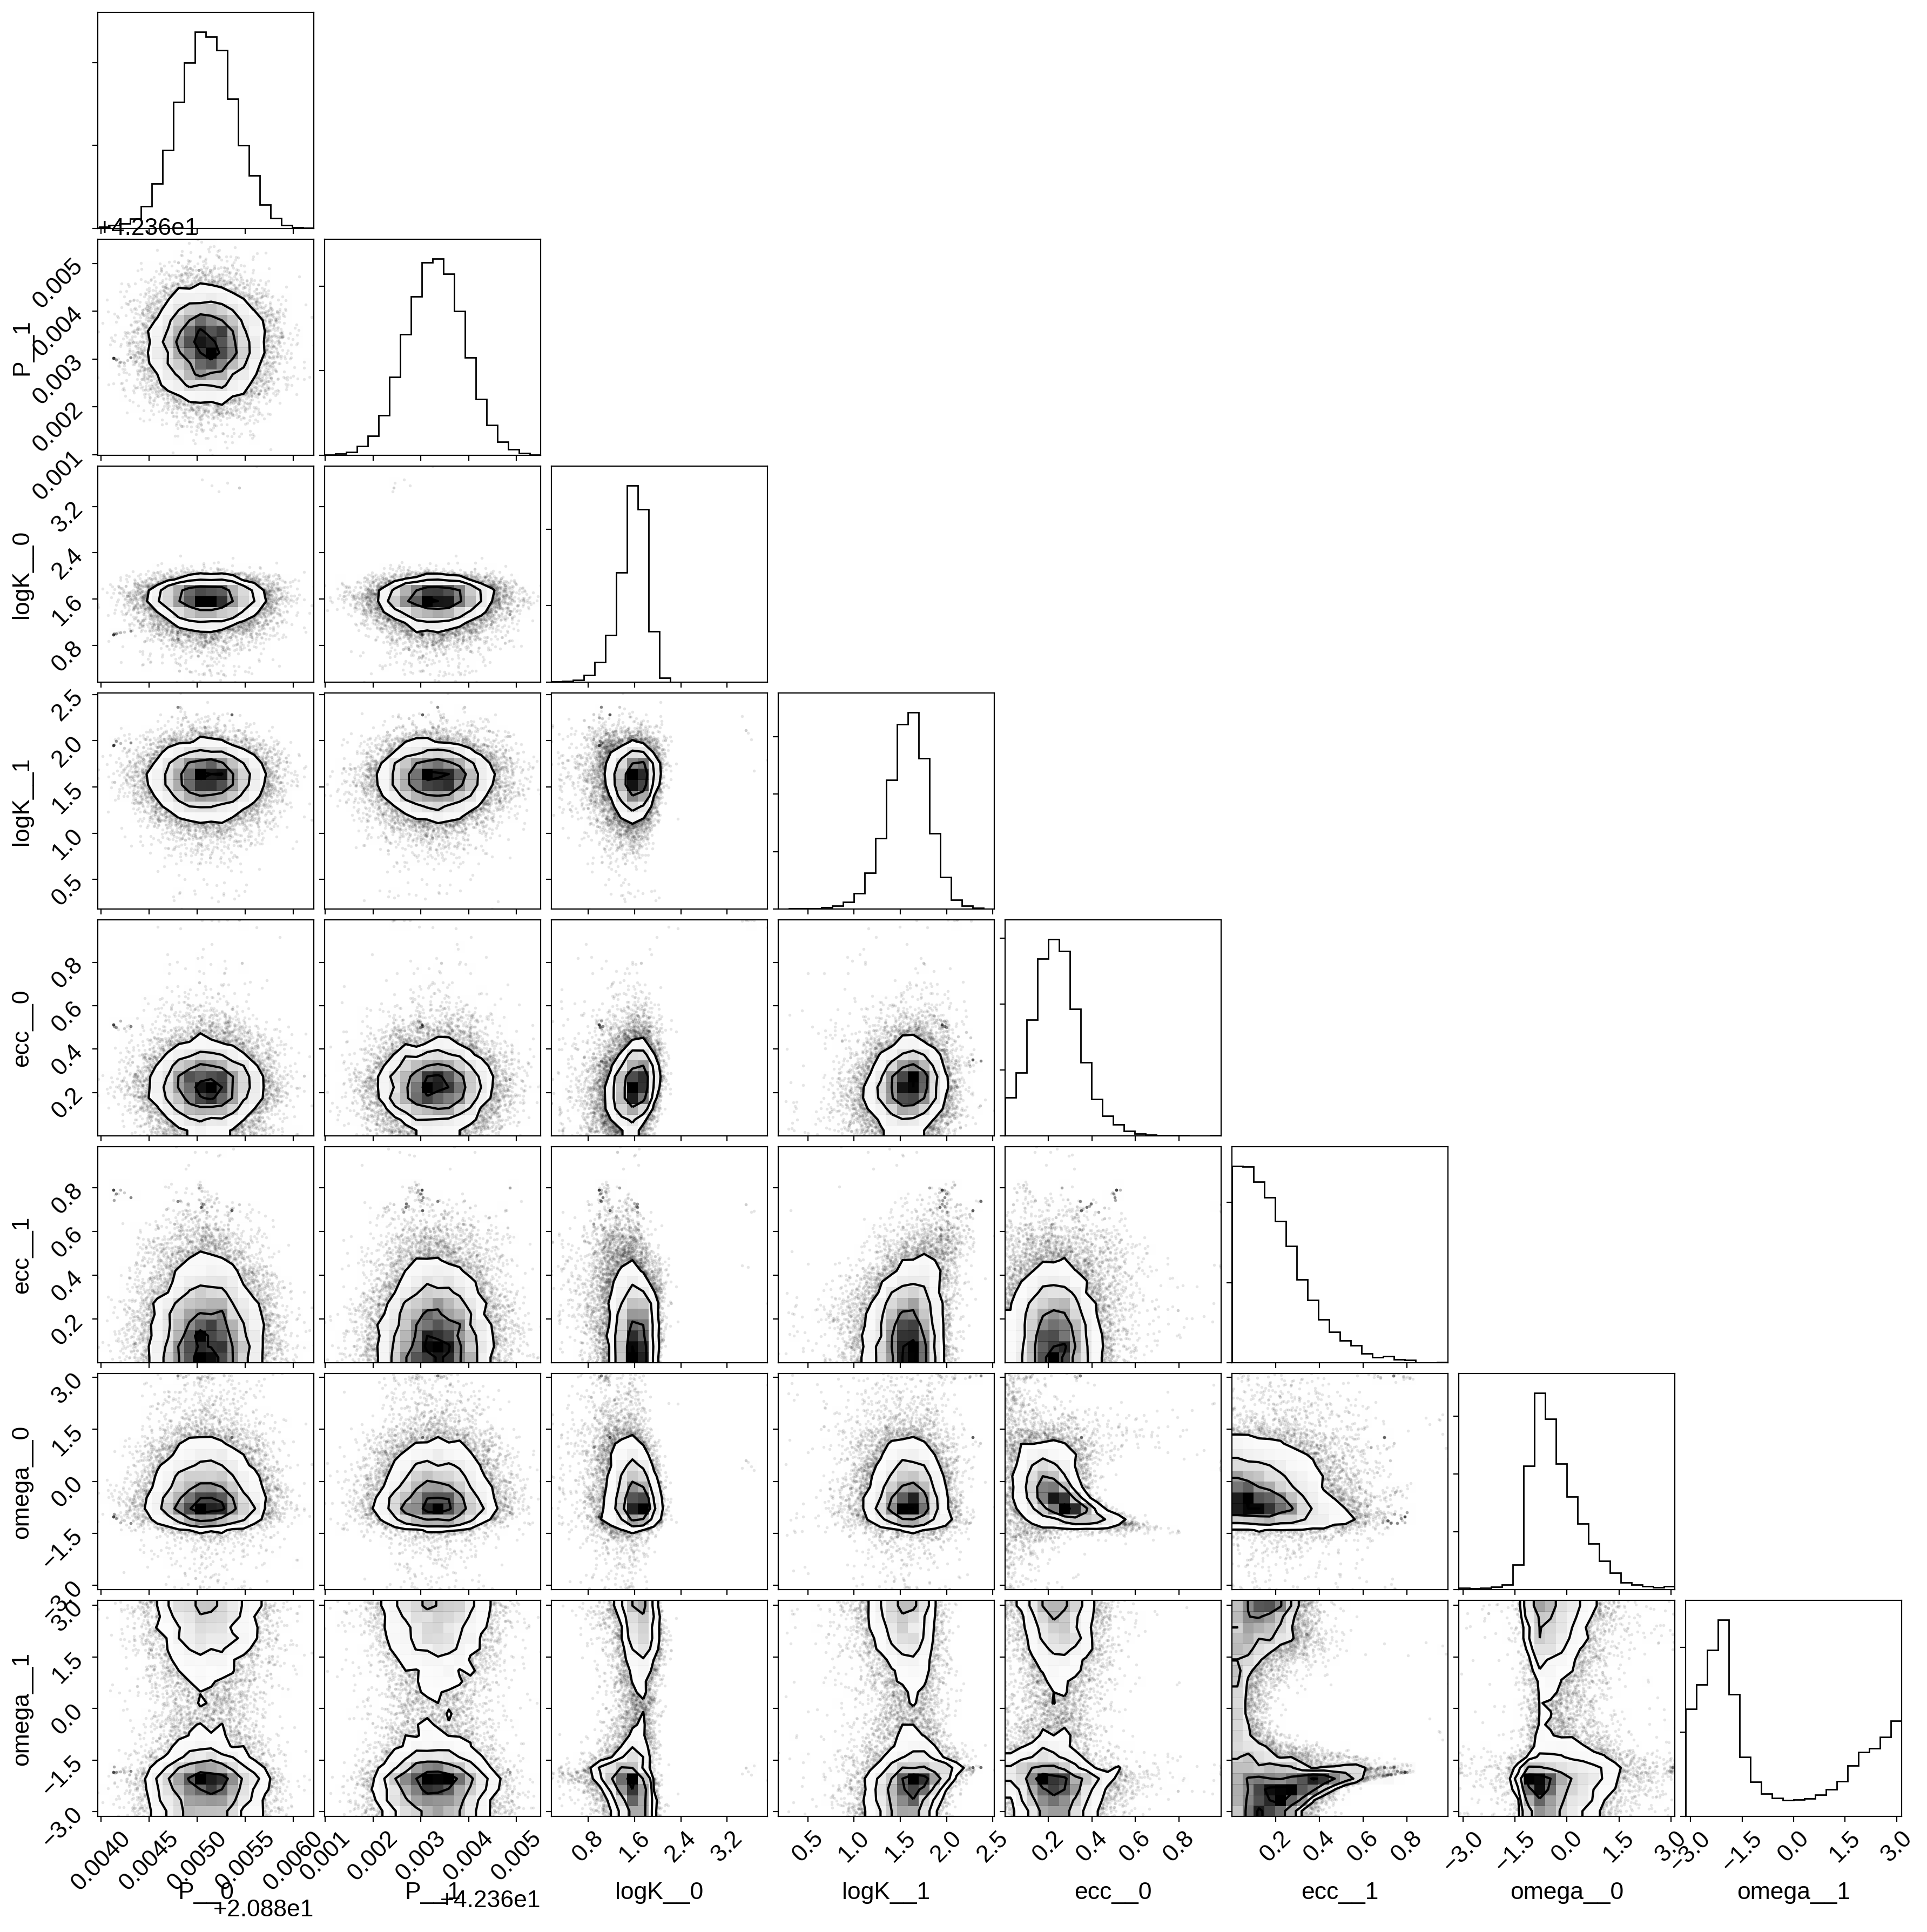

In [13]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

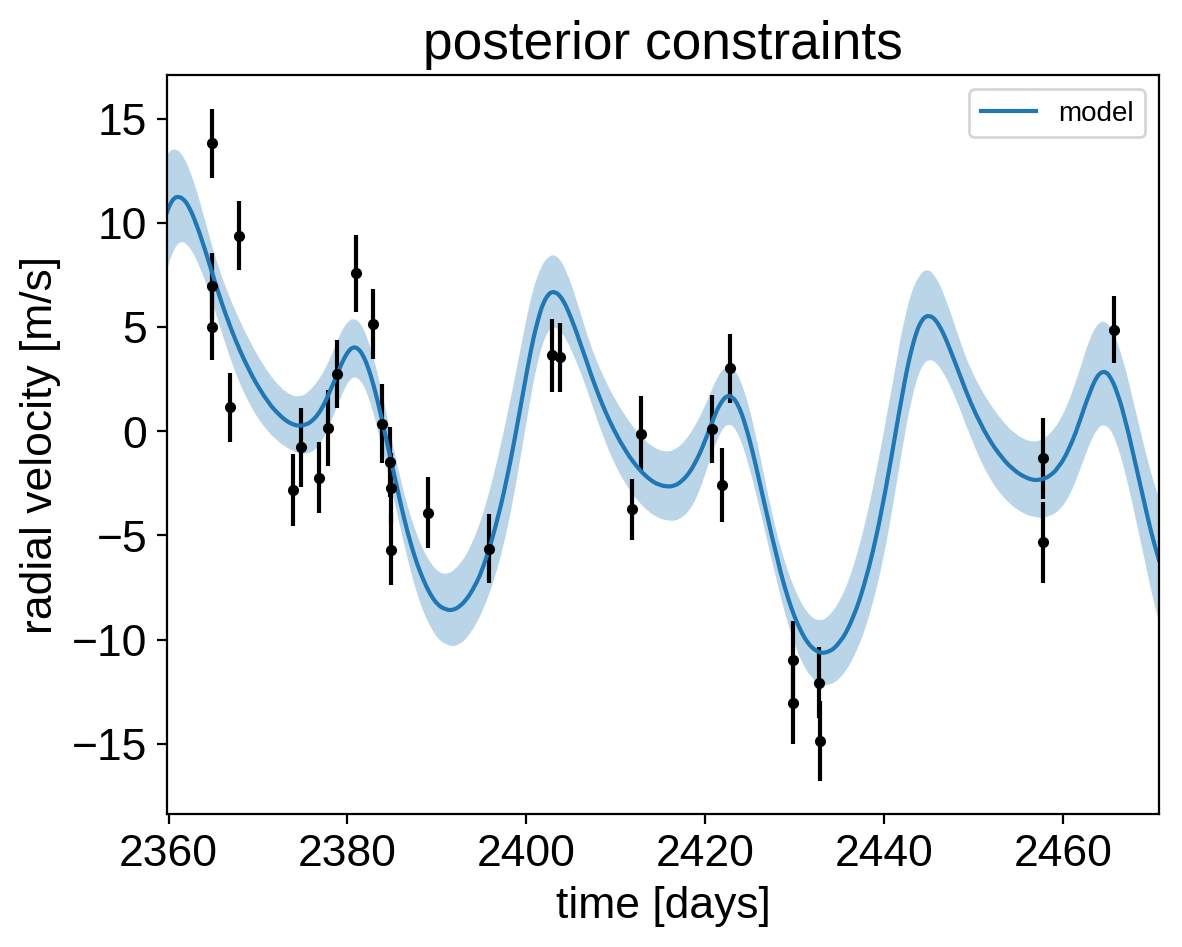

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

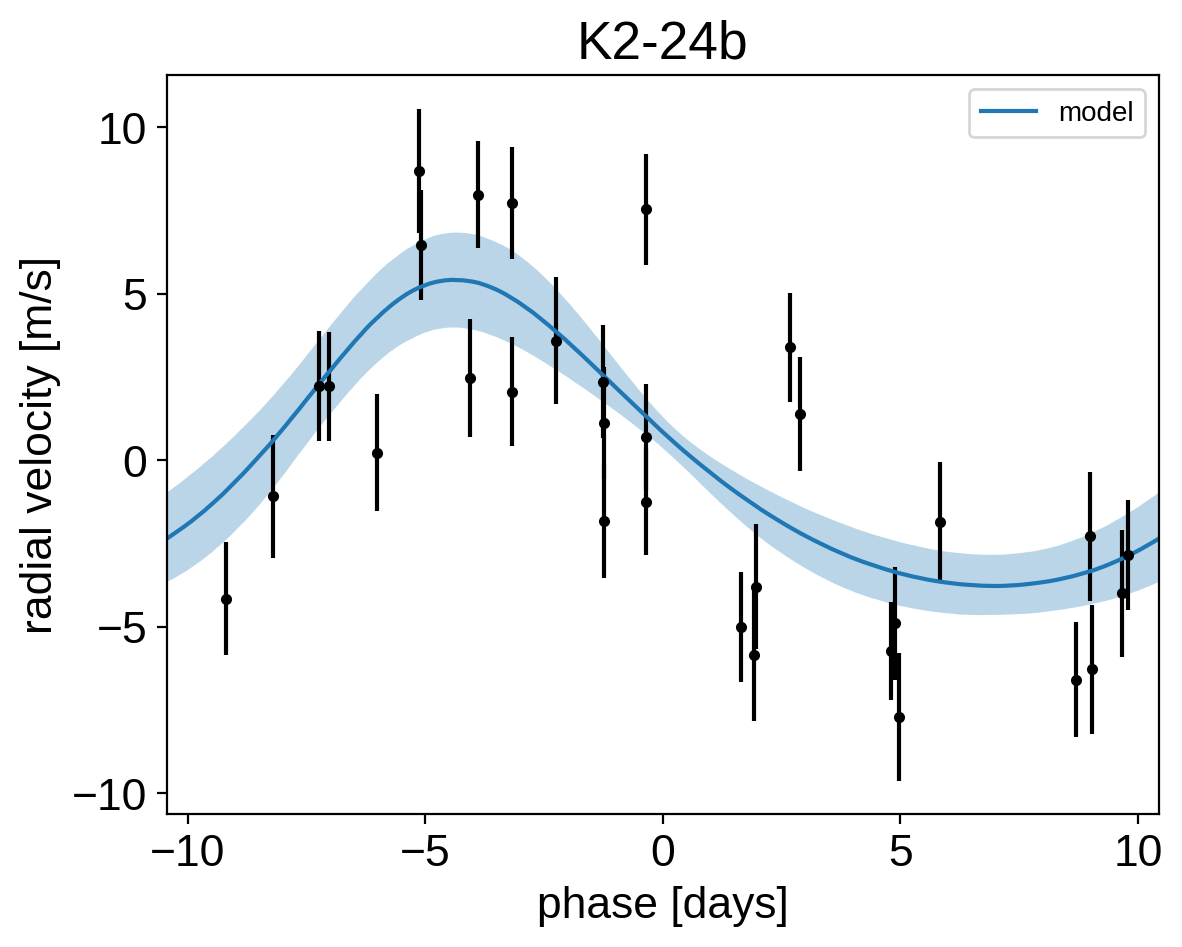

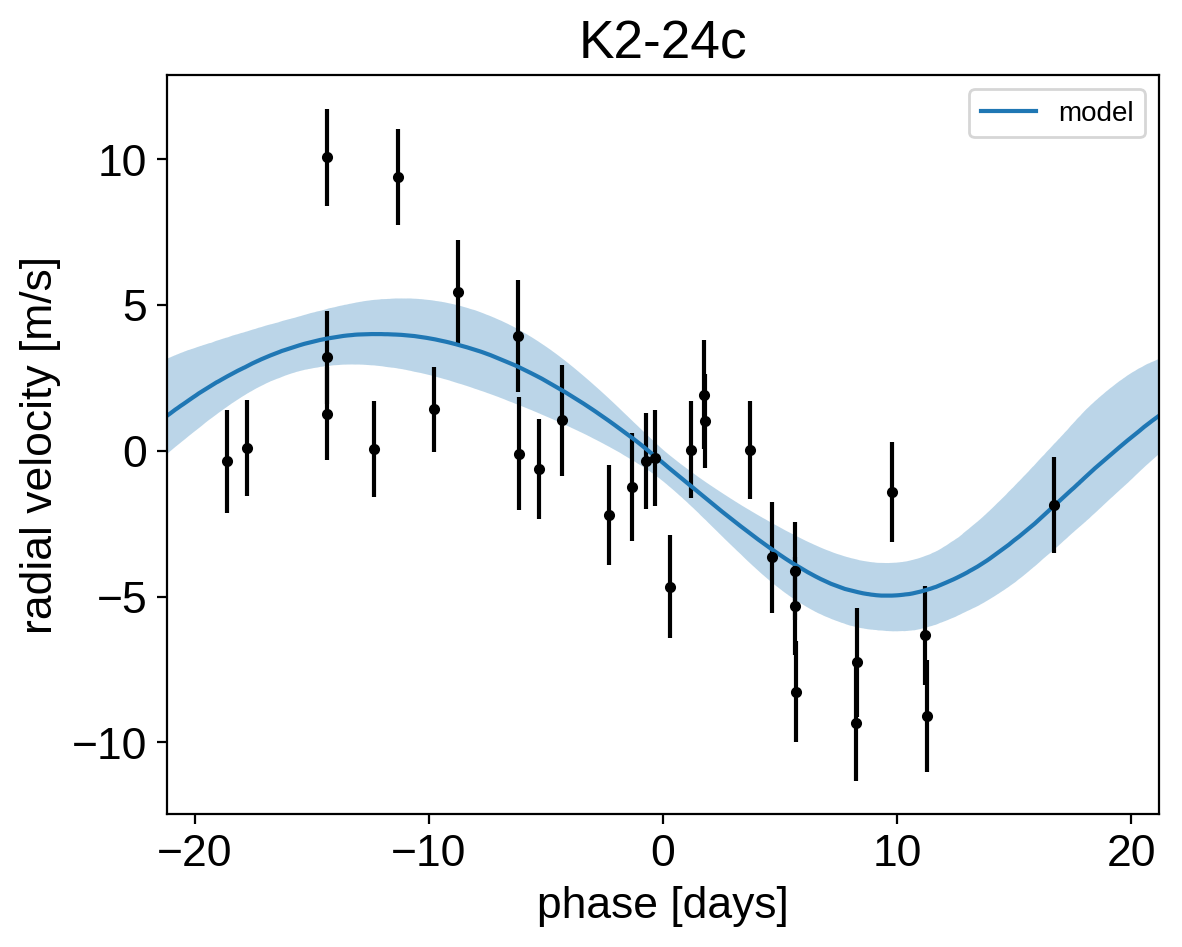

In [15]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [16]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [17]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.1},
   month = sep,
    year = 2019,
     doi = {10.5281/zenodo.3462740},
     url = {https://doi.org/10.5281/zenodo.3462740}
}
...
